In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, ListedColormap
import matplotlib.cm as cm
from scipy.ndimage import gaussian_filter

REQUIRED_COLS = [
    "frame_id","player_id","timestamp_s","x1","y1","x2","y2","cx","cy","w","h","confidence"
]

DEFAULT_FIELD_LENGTH_M = 159.5
DEFAULT_FIELD_WIDTH_M  = 128.8

DEFAULT_NX = 200
DEFAULT_NY = 150
DEFAULT_SIGMA = 2.0


In [ ]:
def raw_bbox(xs, ys, pad_ratio=0.02):
    xmin, xmax = float(np.min(xs)), float(np.max(xs))
    ymin, ymax = float(np.min(ys)), float(np.max(ys))
    dx, dy = max(xmax - xmin, 1e-9), max(ymax - ymin, 1e-9)
    return (xmin - dx*pad_ratio, xmax + dx*pad_ratio,
            ymin - dy*pad_ratio, ymax + dy*pad_ratio)

def raw_to_metres(x, y, bbox_raw, a, b):
    xmin, xmax, ymin, ymax = bbox_raw
    x_m = ((x - xmin) / max(1e-9, (xmax - xmin))) * (2*a) - a
    y_m = ((y - ymin) / max(1e-9, (ymax - ymin))) * (2*b) - b
    return x_m, y_m

def make_oval_mask_metres(nx, ny, a, b):
    x_edges = np.linspace(-a, a, nx + 1)
    y_edges = np.linspace(-b, b, ny + 1)
    xc = (x_edges[:-1] + x_edges[1:]) / 2
    yc = (y_edges[:-1] + y_edges[1:]) / 2
    Xc, Yc = np.meshgrid(xc, yc)
    mask = (Xc**2) / (a**2) + (Yc**2) / (b**2) <= 1.0
    return x_edges, y_edges, mask

def heatmap_in_metres(x_raw, y_raw, bbox_raw, a, b, nx, ny, sigma, weights=None):
    x_m, y_m = raw_to_metres(np.asarray(x_raw,float), np.asarray(y_raw,float), bbox_raw, a, b)
    x_edges, y_edges, mask = make_oval_mask_metres(nx, ny, a, b)
    H, _, _ = np.histogram2d(x_m, y_m, bins=[x_edges, y_edges], weights=weights)
    H = H.T
    Hs = gaussian_filter(H, sigma=sigma)
    return np.where(mask, Hs, np.nan), x_edges, y_edges


In [ ]:
def plot_heatmap_on_field_metres(
    H, x_edges, y_edges, a, b,
    title="Heatmap", alpha_img=0.9, out_path=None,
    cutoff_percentile=30
):

    fig, ax = plt.subplots(figsize=(11, 8))

    # 1. Green oval background
    t = np.linspace(0, 2*np.pi, 600)
    grass = (0.5, 0.1, 0.5) # Changed grass color to purple
    ax.fill(a * np.cos(t), b * np.sin(t), color=grass, alpha=1.0, zorder=0)
    ax.set_xlim([-a, a])
    ax.set_ylim([-b, b])
    ax.set_aspect("equal")
    ax.set_axis_off()

    # 2. Cut off low values (remove purple haze)
    finite = H[np.isfinite(H)]
    vmin = np.nanpercentile(finite[finite > 0], cutoff_percentile)
    vmax = np.nanpercentile(finite, 99)
    H_masked = np.where(H >= vmin, H, np.nan)

    # 3. Transparent colormap for low values and NaNs
    cmap = cm.get_cmap("viridis").copy()
    # Make the lowest values transparent
    cmap.set_under(color=(0, 0, 0, 0))
    cmap.set_bad((0, 0, 0, 0))  # Transparent for NaNs


    # 4. Plot heatmap
    extent = [x_edges.min(), x_edges.max(), y_edges.min(), y_edges.max()]
    im = ax.imshow(
        H_masked, origin="lower", extent=extent, aspect="equal",
        interpolation="bilinear", cmap=cmap,
        norm=Normalize(vmin=vmin, vmax=vmax, clip=True), # Use clip=True to handle values below vmin
        alpha=alpha_img, zorder=2
    )

    # 5. Field lines
    draw_afl_field_metres(ax, a, b, show_ticks=False)

    # 6. Scale bar
    sb_y = -b + 8
    sb_x0, sb_x1 = -a + 12, -a + 32
    ax.plot([sb_x0, sb_x1], [sb_y, sb_y], color="white", lw=4, alpha=0.95)
    ax.text((sb_x0 + sb_x1)/2, sb_y - 4, "20 m", ha="center", va="top",
            color="white", fontsize=11)

    # 7. Title + colorbar
    ax.set_title(title, color="white")
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("Intensity")

    # 8. Save
    plt.tight_layout()
    if out_path:
        out_dir = os.path.dirname(out_path)
        if out_dir:
            os.makedirs(out_dir, exist_ok=True)
        fig.savefig(out_path, dpi=220)
    plt.show()
    plt.close(fig)

In [ ]:
def plot_heatmap_on_field_metres(
    H, x_edges, y_edges, a, b,
    title="Heatmap", alpha_img=0.9, out_path=None
):
    import numpy as np
    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    from matplotlib.colors import Normalize
    import os

    fig, ax = plt.subplots(figsize=(11, 8))

    # Green oval background
    t = np.linspace(0, 2*np.pi, 600)
    ax.fill(a * np.cos(t), b * np.sin(t), color=(0.05, 0.35, 0.05), alpha=1.0, zorder=0)
    ax.set_xlim([-a, a])
    ax.set_ylim([-b, b])
    ax.set_aspect("equal")
    ax.set_axis_off()

    # Normalize color range
    finite_vals = H[np.isfinite(H)]
    vmin = np.nanmin(finite_vals) if finite_vals.size else 0.01
    vmax = np.nanpercentile(finite_vals, 99) if finite_vals.size else 1.0

    # Heatmap with default viridis colormap (includes purple)
    extent = [x_edges.min(), x_edges.max(), y_edges.min(), y_edges.max()]
    im = ax.imshow(
        H, origin="lower", extent=extent, aspect="equal",
        interpolation="bilinear", cmap="viridis",
        norm=Normalize(vmin=vmin, vmax=vmax, clip=True),
        alpha=alpha_img, zorder=2
    )

    # Field lines
    draw_afl_field_metres(ax, a, b, show_ticks=False)

    # Scale bar
    sb_y = -b + 8
    sb_x0, sb_x1 = -a + 12, -a + 32
    ax.plot([sb_x0, sb_x1], [sb_y, sb_y], color="white", lw=4, alpha=0.95)
    ax.text((sb_x0 + sb_x1)/2, sb_y - 4, "20 m", ha="center", va="top",
            color="white", fontsize=11)

    # Title and colorbar
    ax.set_title(title, color="white")
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("Intensity")

    # Save image
    plt.tight_layout()
    if out_path:
        out_dir = os.path.dirname(out_path)
        if out_dir:
            os.makedirs(out_dir, exist_ok=True)
        fig.savefig(out_path, dpi=220)
    plt.show()
    plt.close(fig)


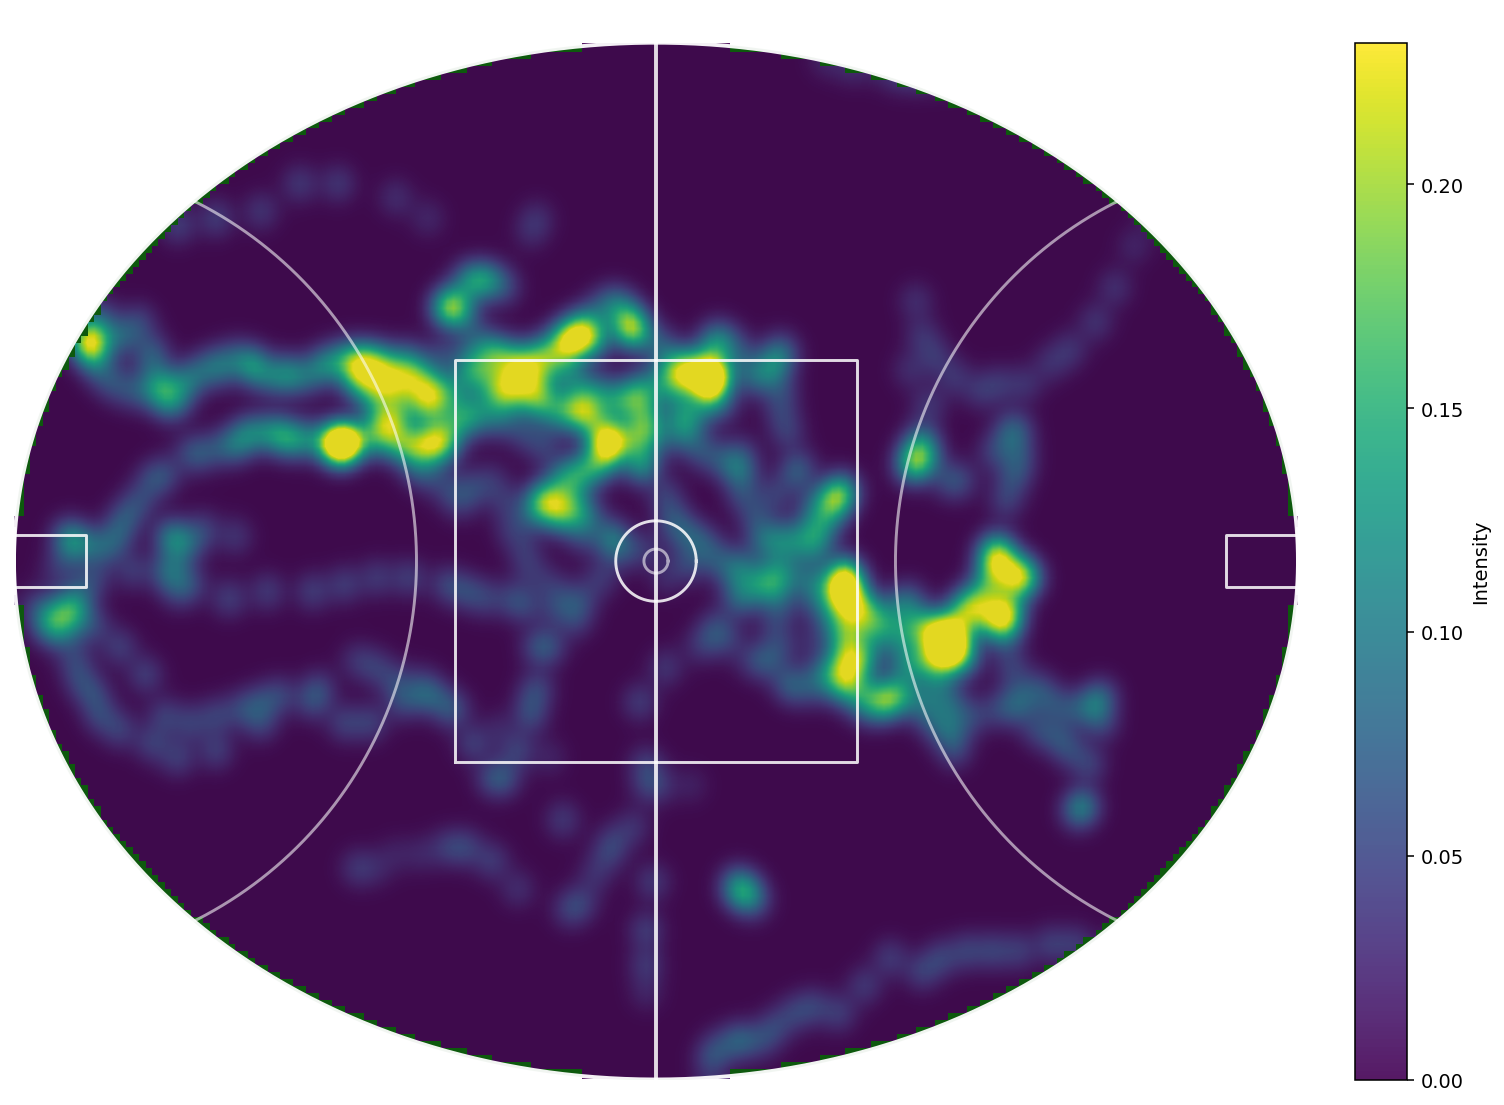

In [ ]:
# 🔧 Change this to your CSV file path
csv_path = "tracking_csv.csv"
df = load_events_csv(csv_path)

a = DEFAULT_FIELD_LENGTH_M / 2.0
b = DEFAULT_FIELD_WIDTH_M  / 2.0

bbox = raw_bbox(df["cx"], df["cy"])
weights = choose_weights(df, "confidence")

H, xe, ye = heatmap_in_metres(df["cx"], df["cy"], bbox, a, b, DEFAULT_NX, DEFAULT_NY, DEFAULT_SIGMA, weights)
plot_heatmap_on_field_metres(H, xe, ye, a, b, title="Heatmap", out_path="heatmap_output.png")


In [ ]:
unique_player_ids = df['player_id'].unique()
print("Unique player IDs:")
for player_id in unique_player_ids:
    print(player_id)

Unique player IDs:
1
2
5
34
36
45
49
50
55
62
63
64
69
70
72
73
78
79
3
4
86
87
88
98


In [ ]:

output_dir = "outputs/individual_heatmaps"
os.makedirs(output_dir, exist_ok=True)


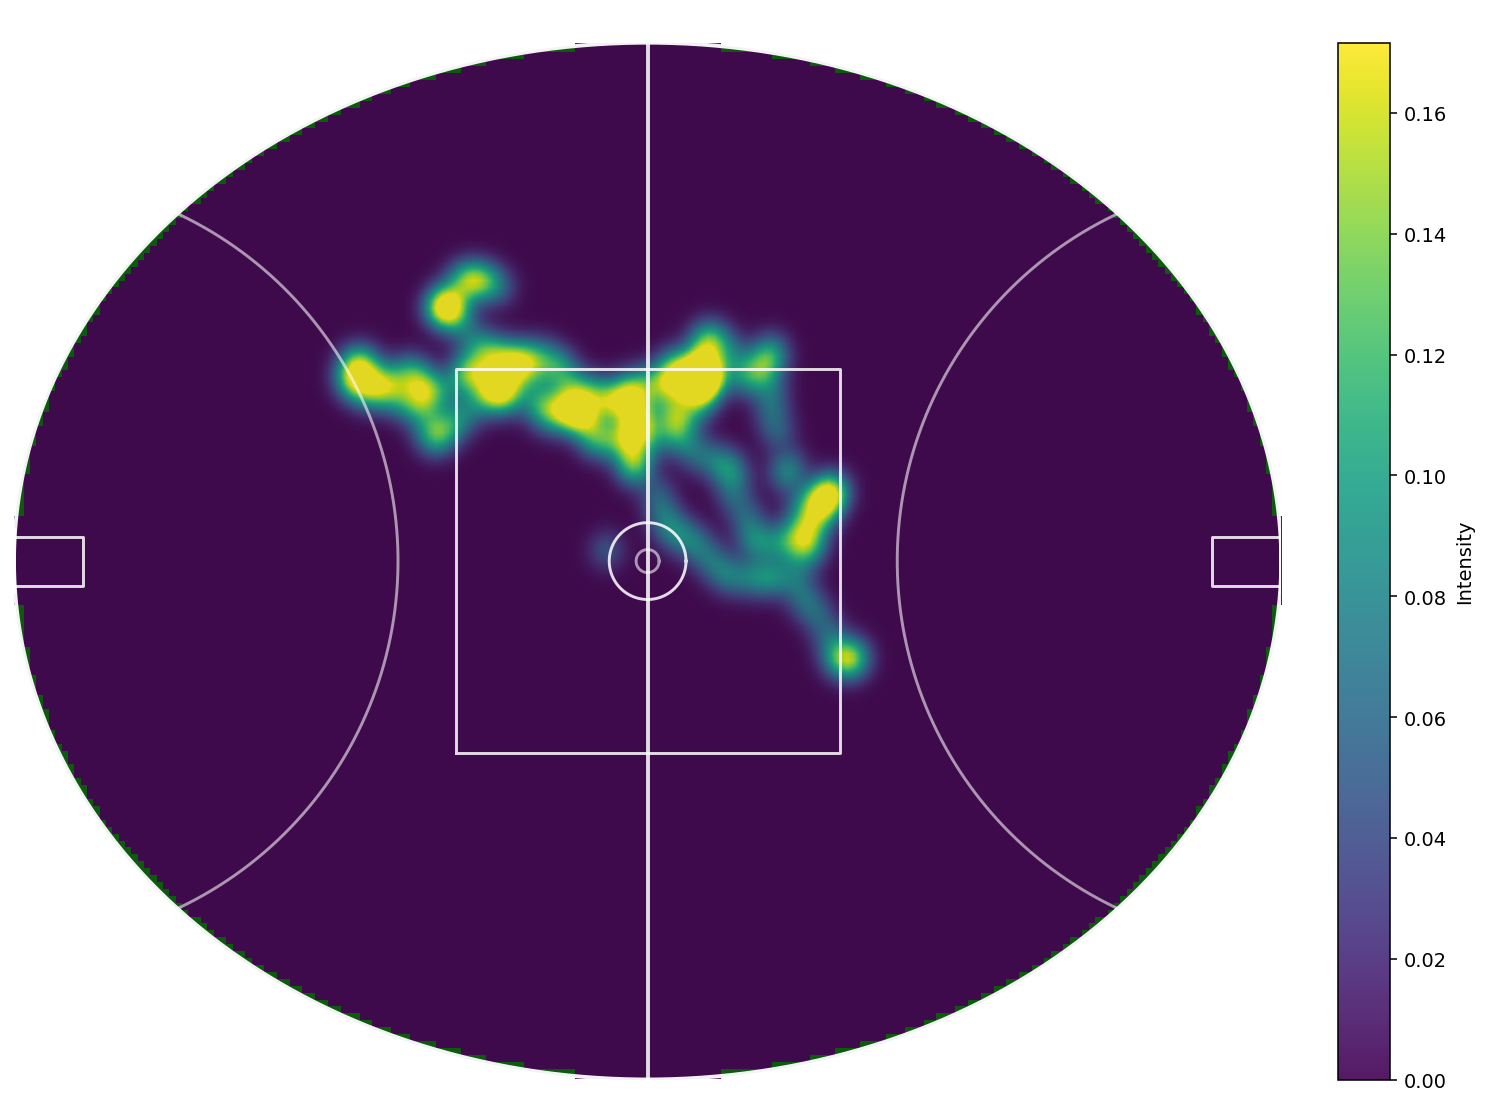

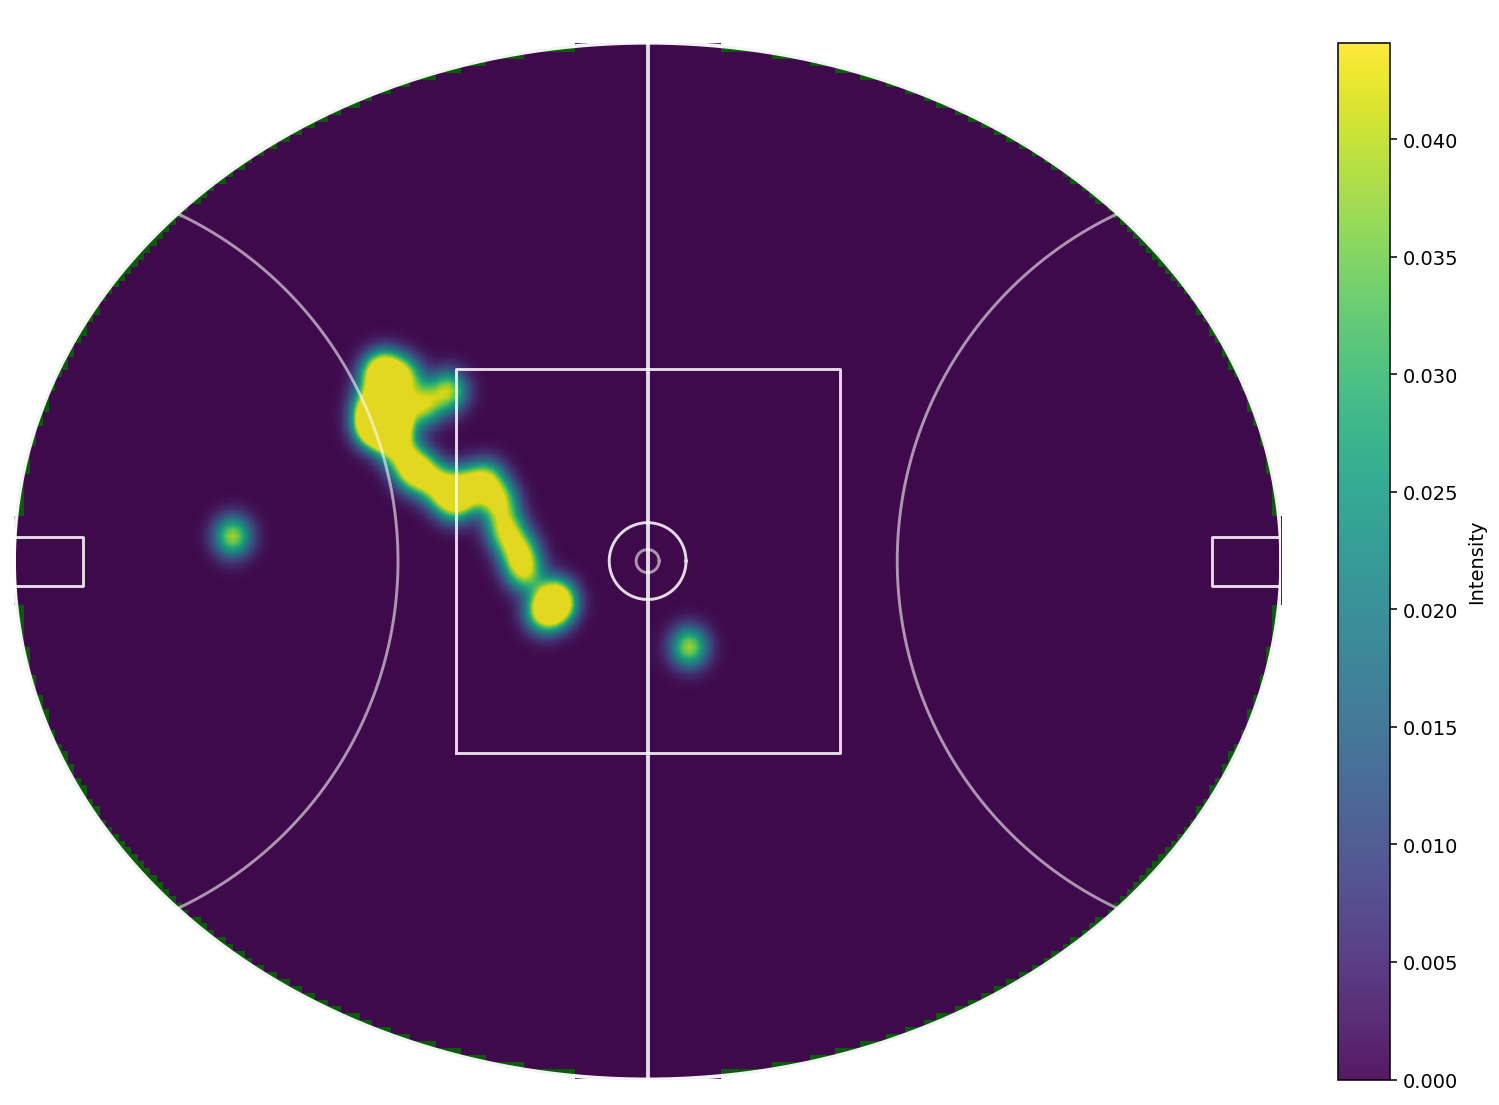

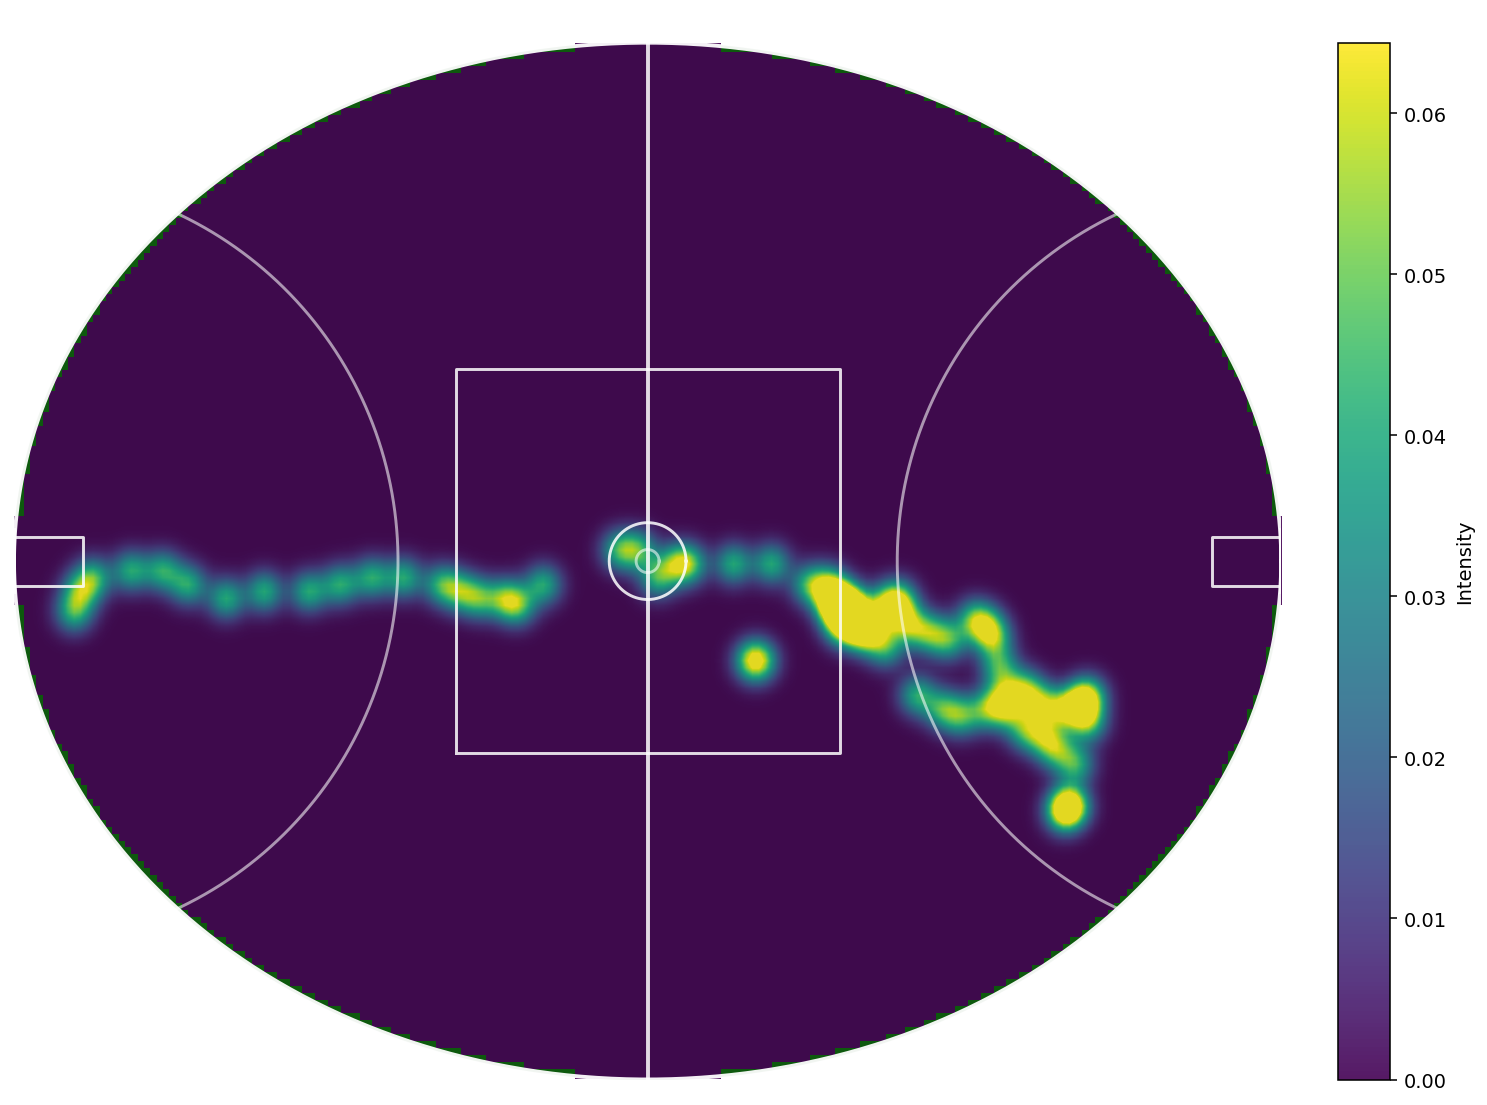

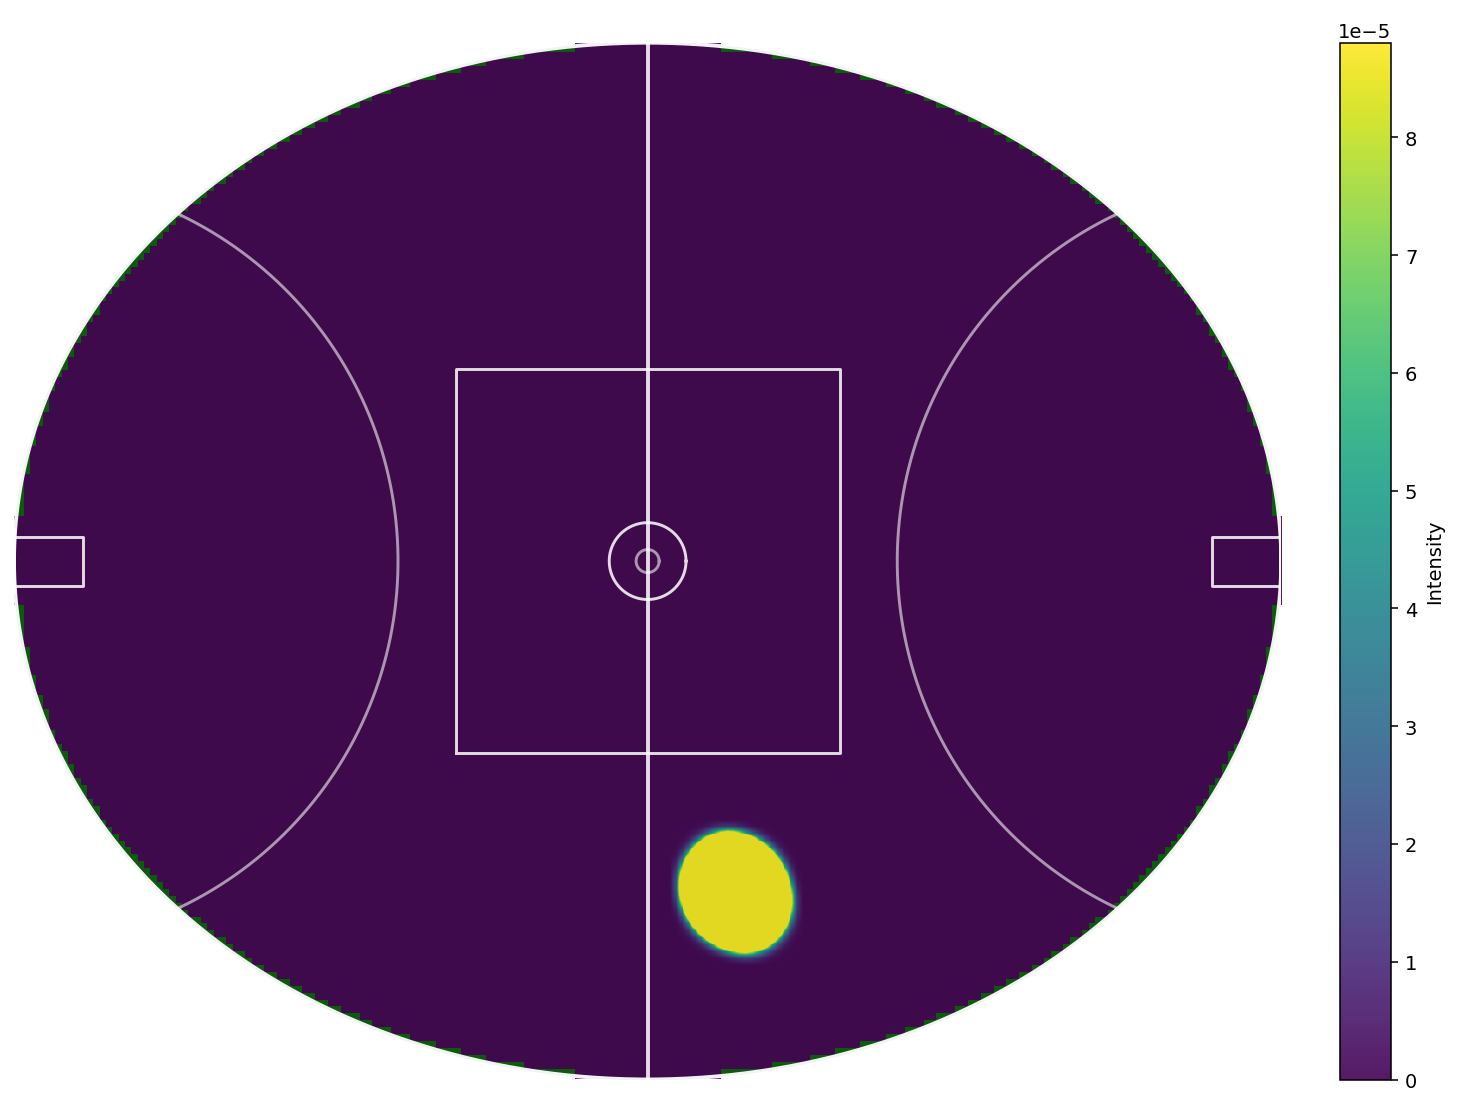

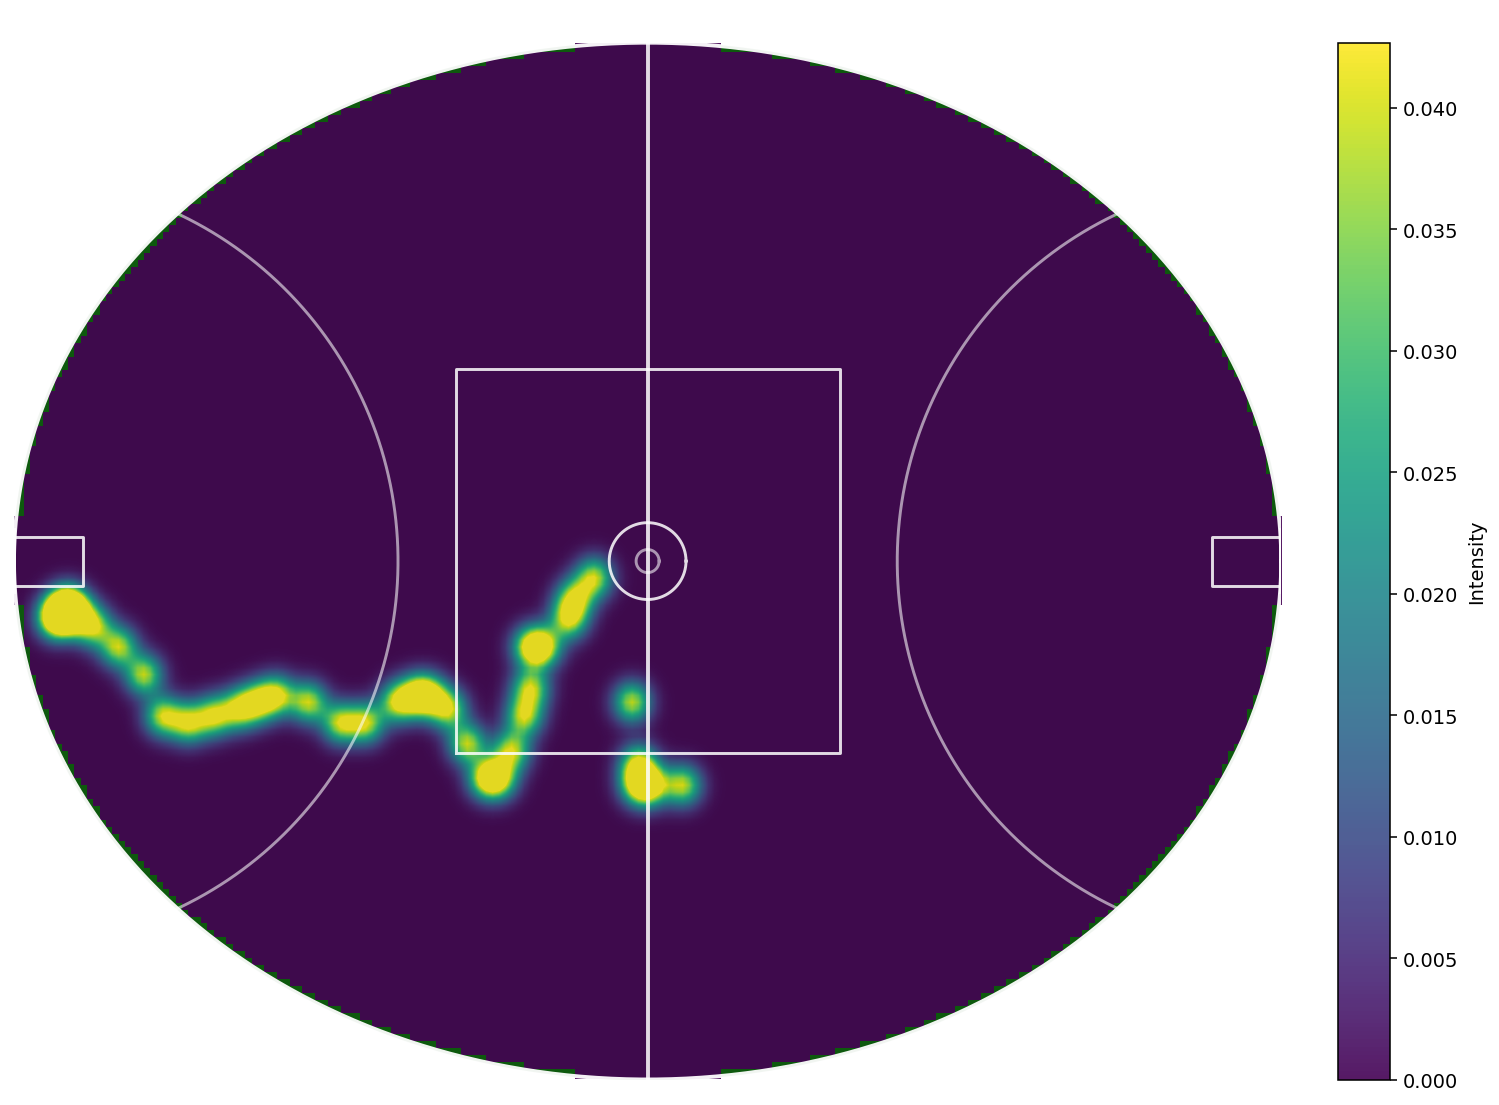

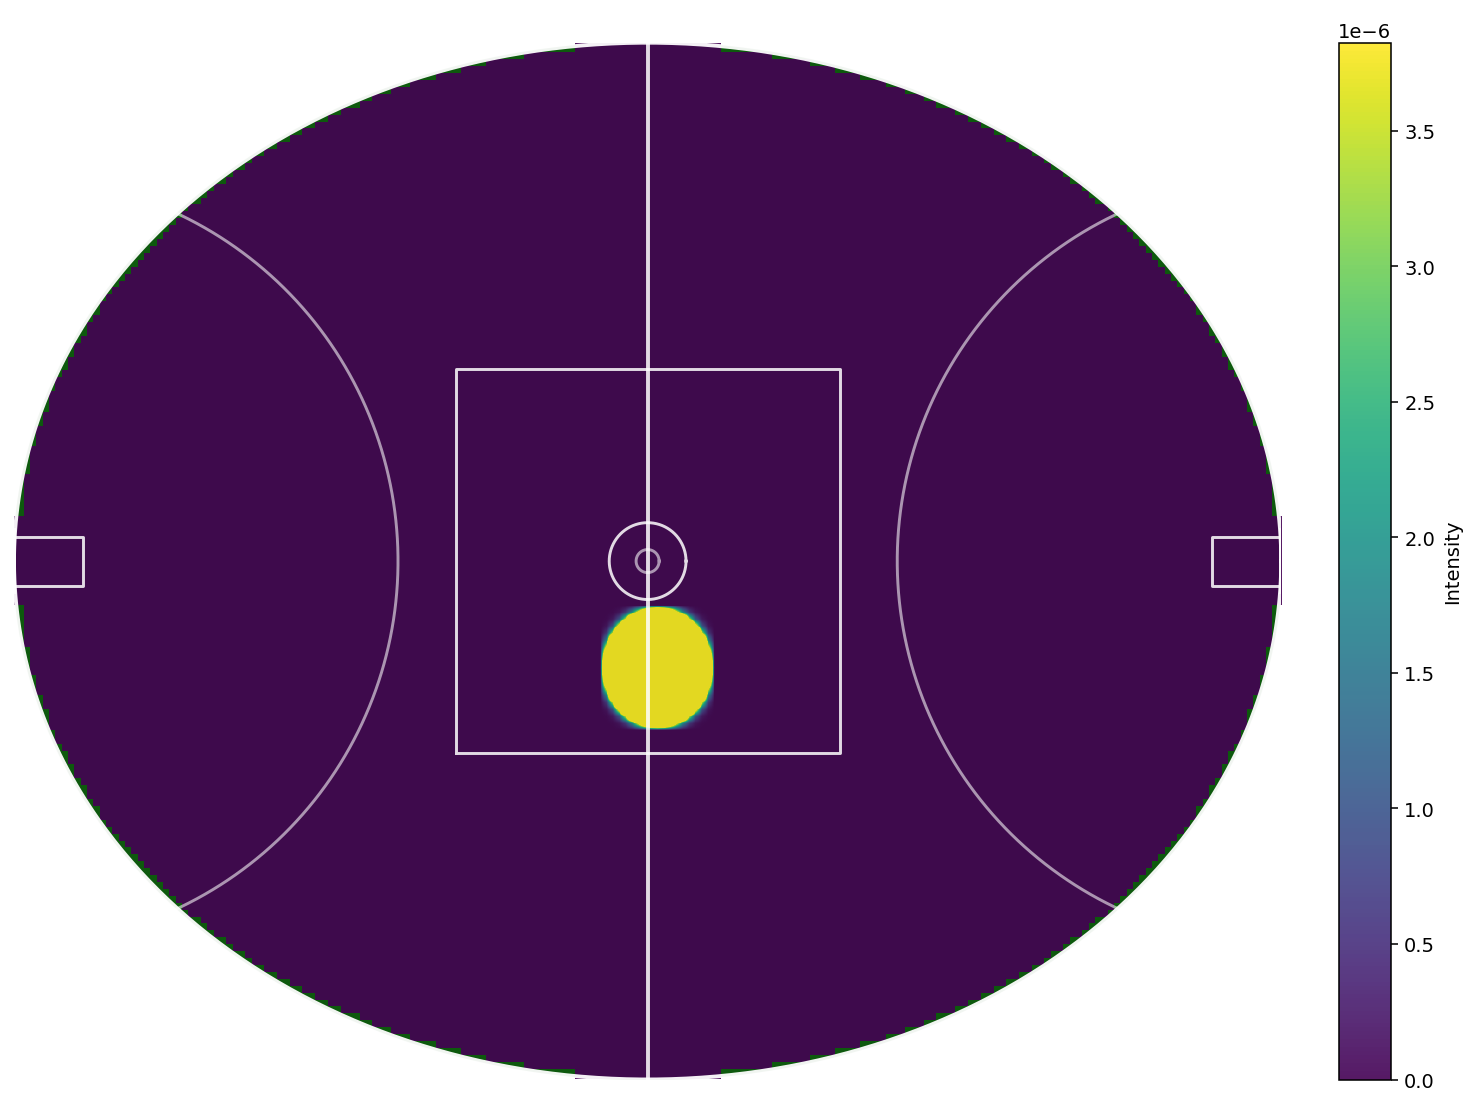

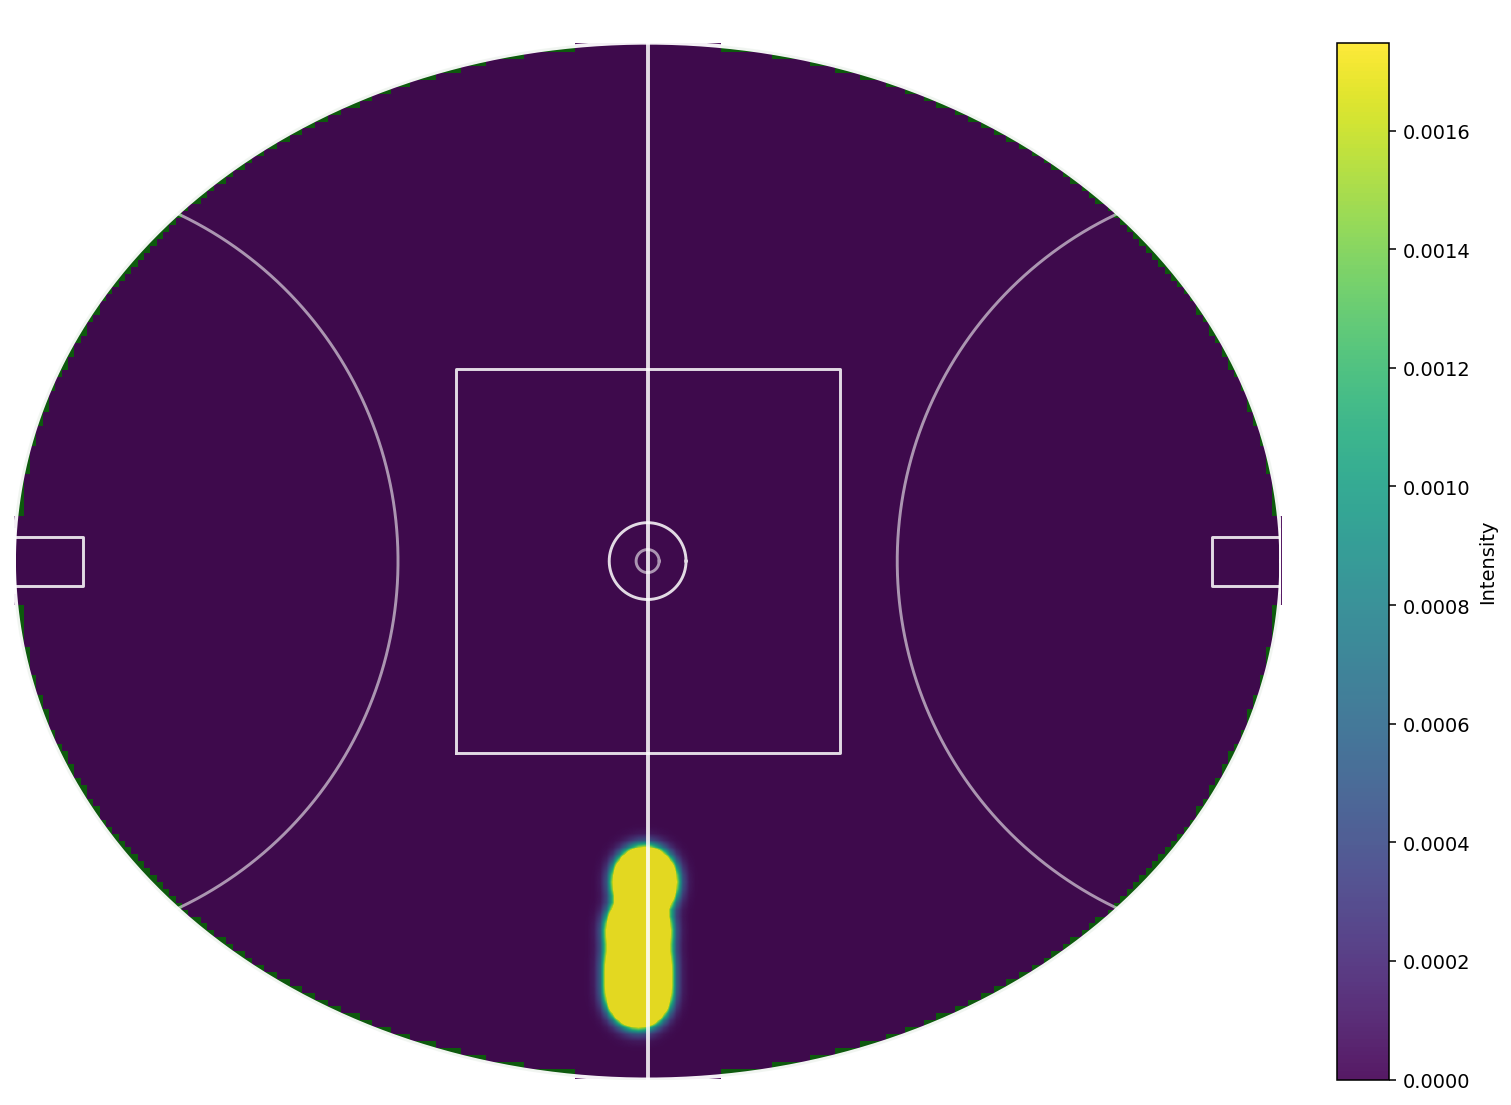

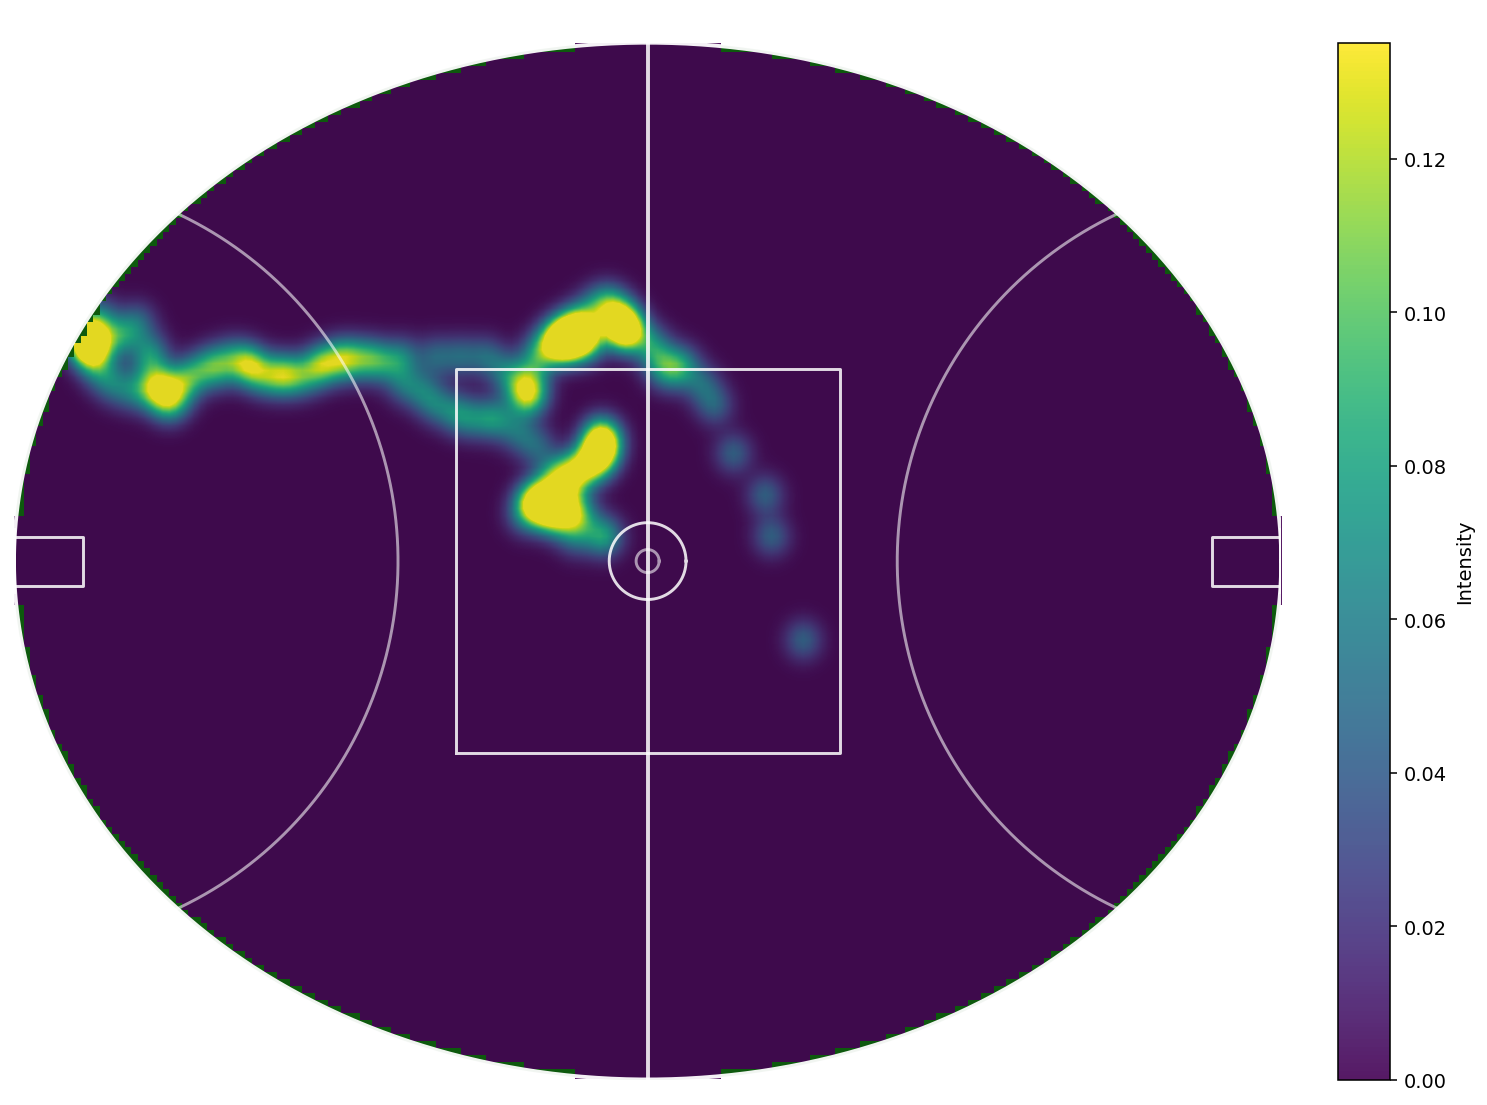

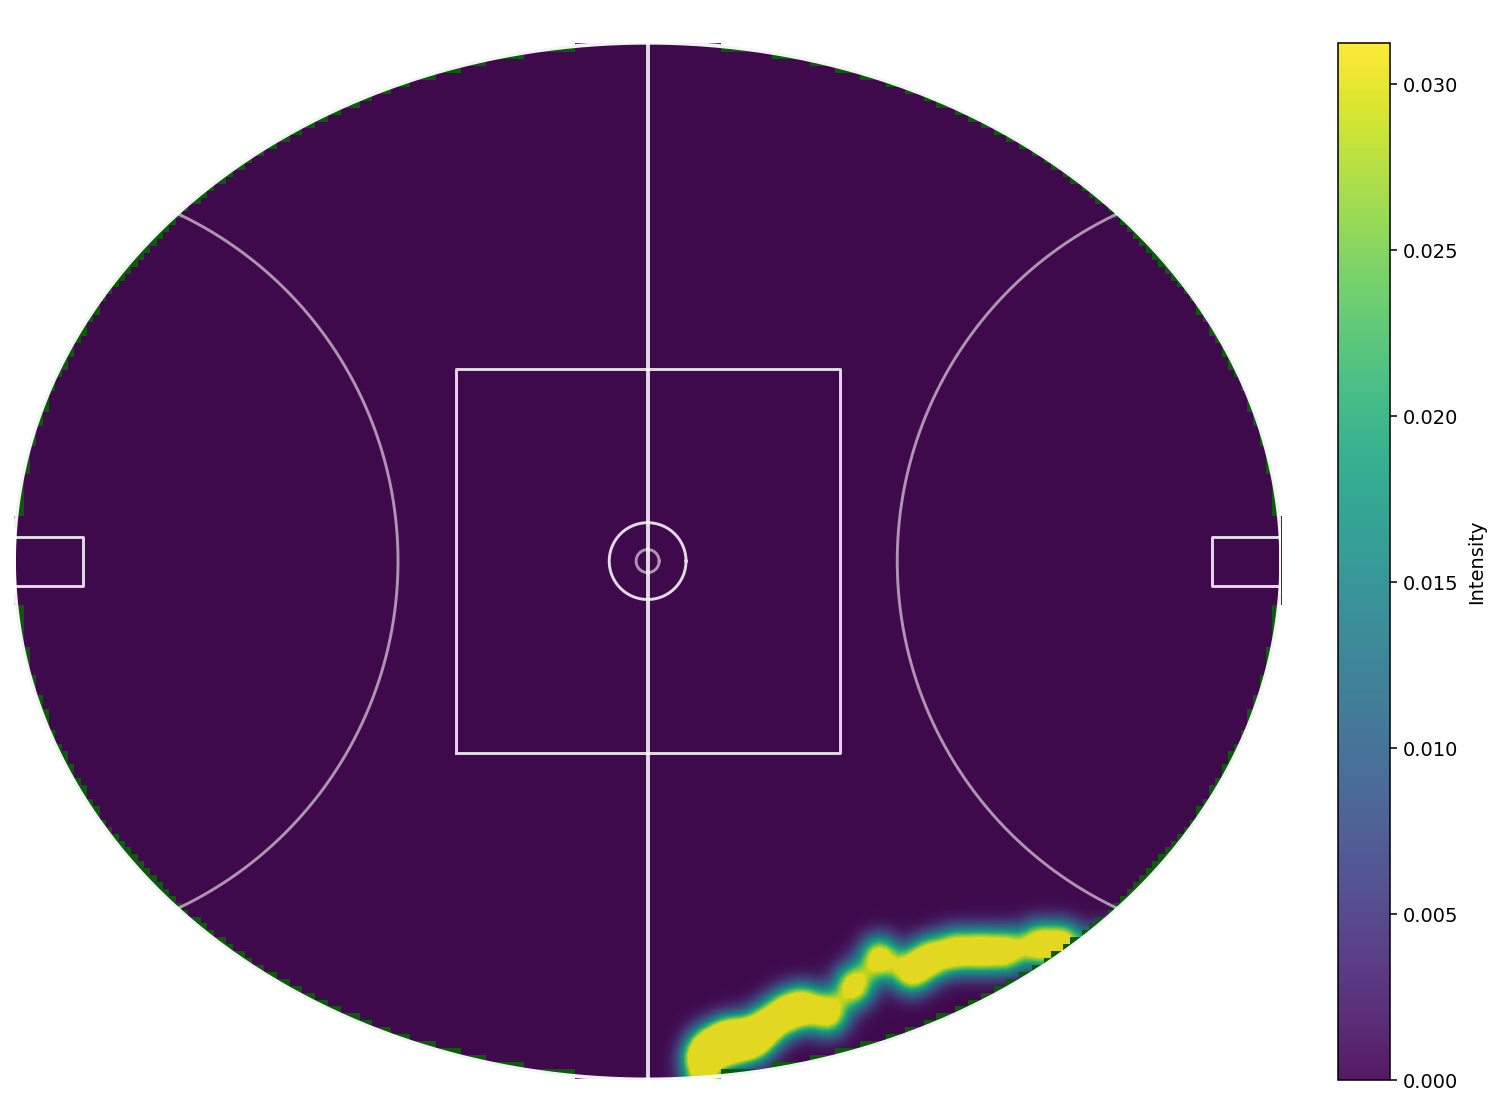

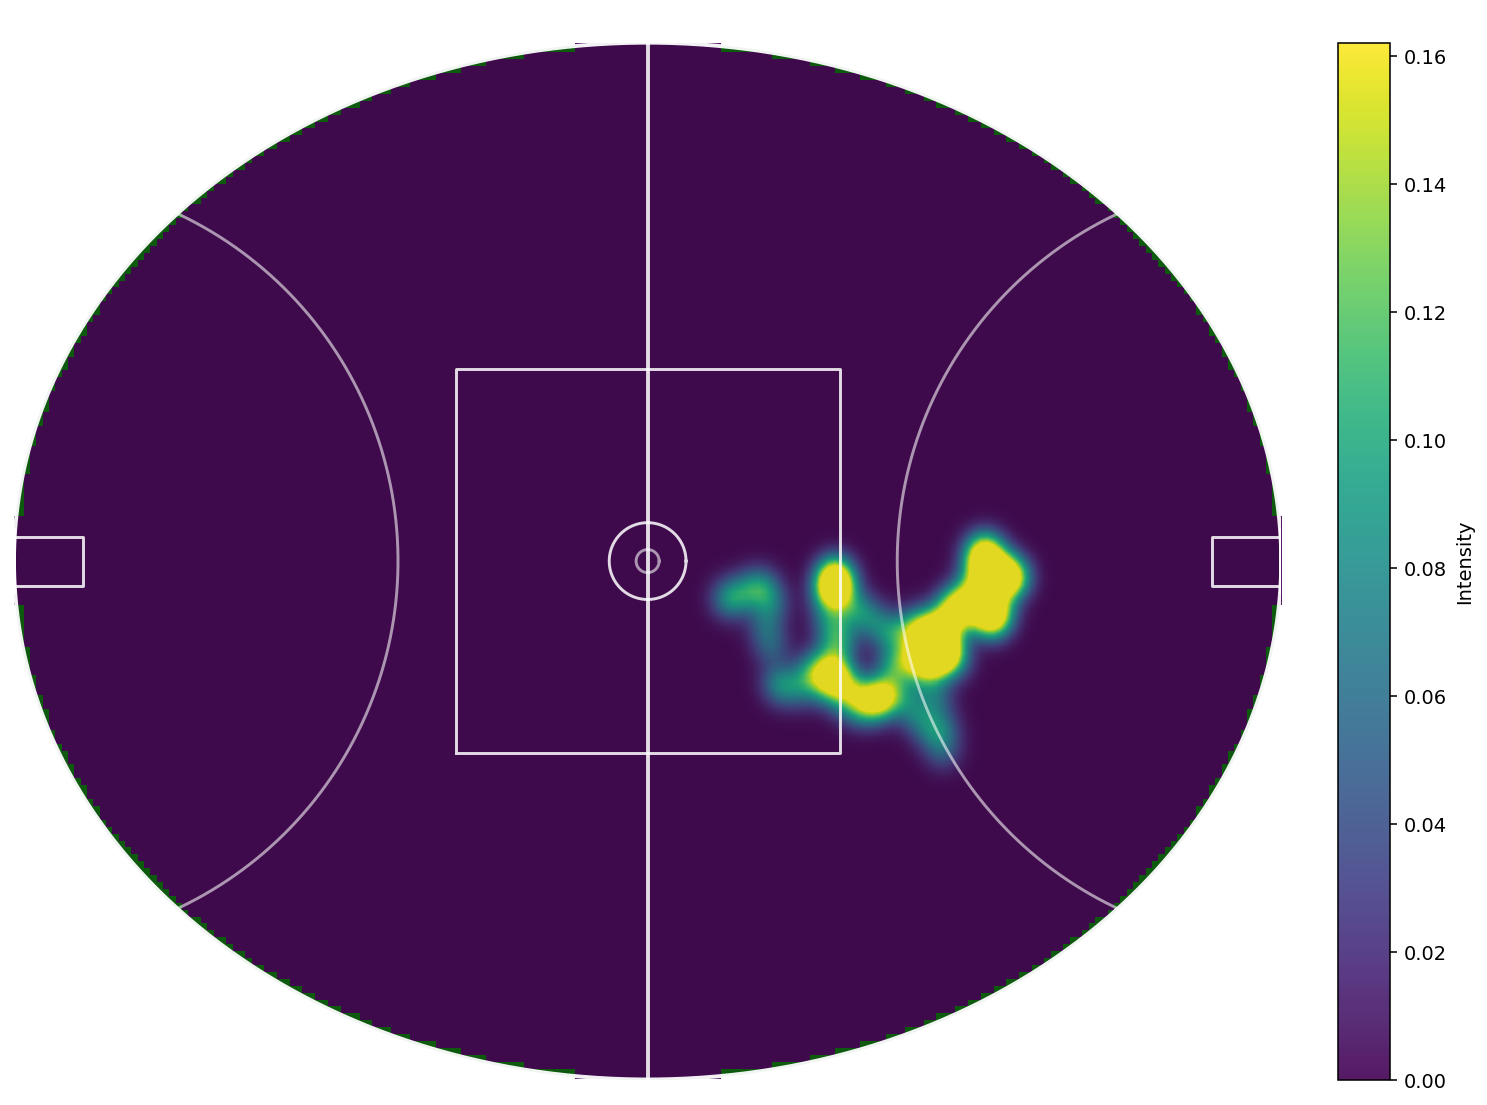

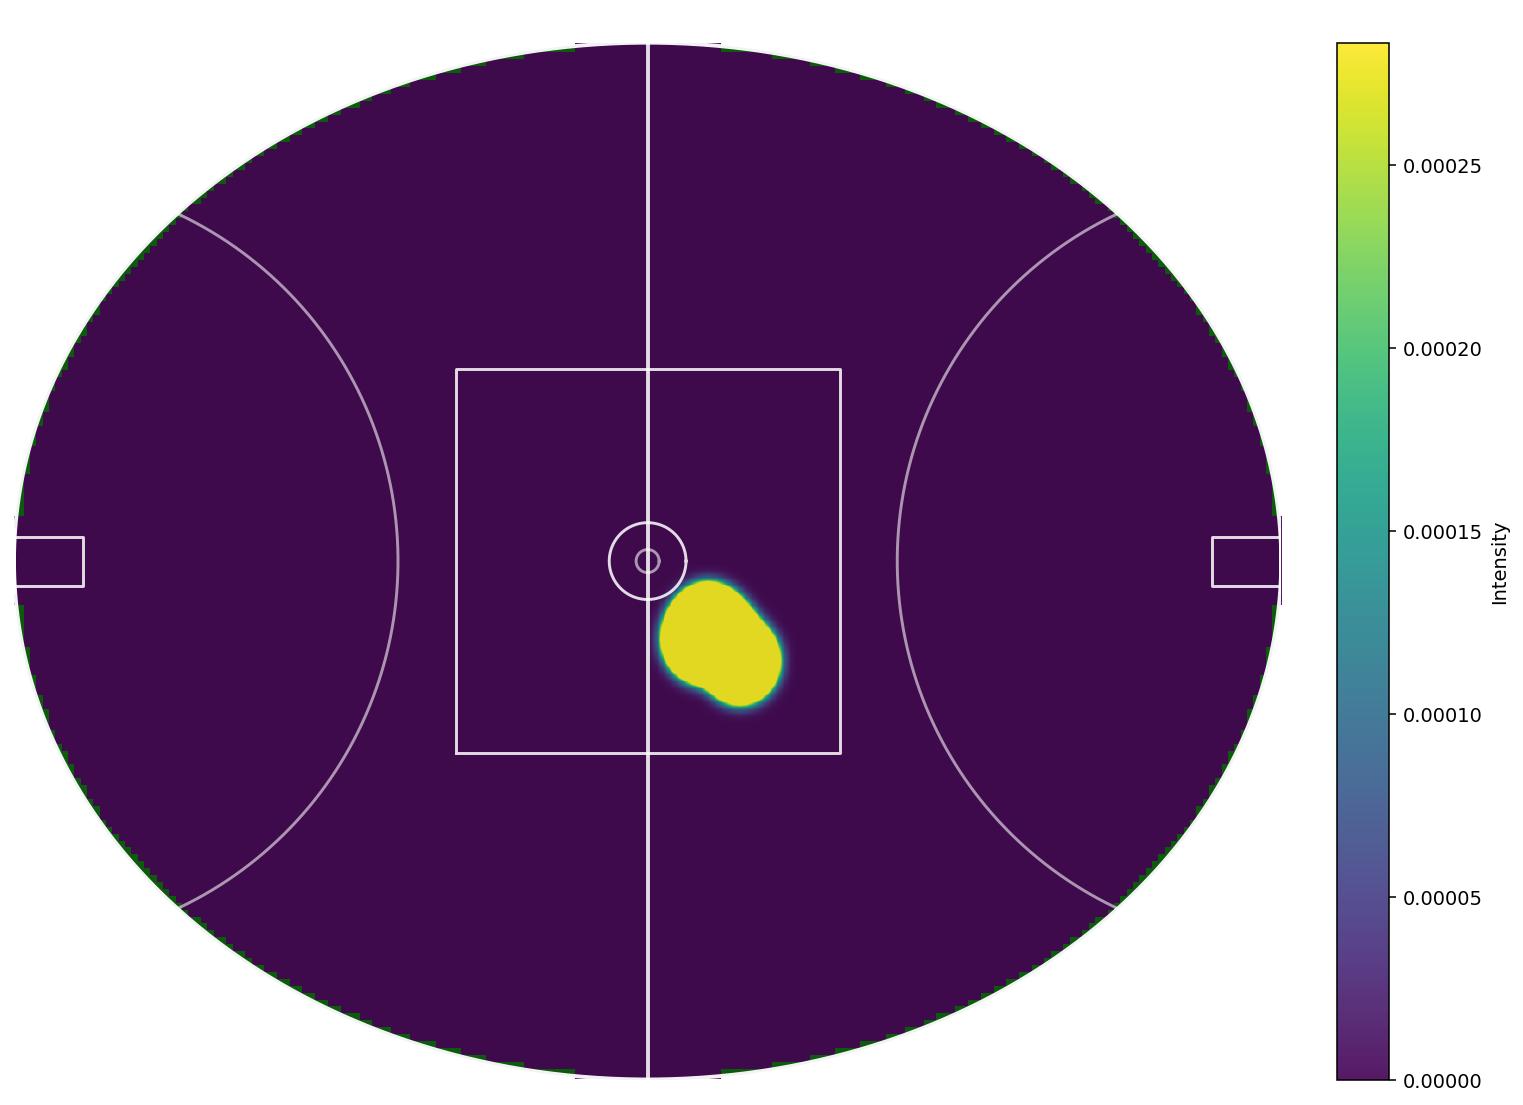

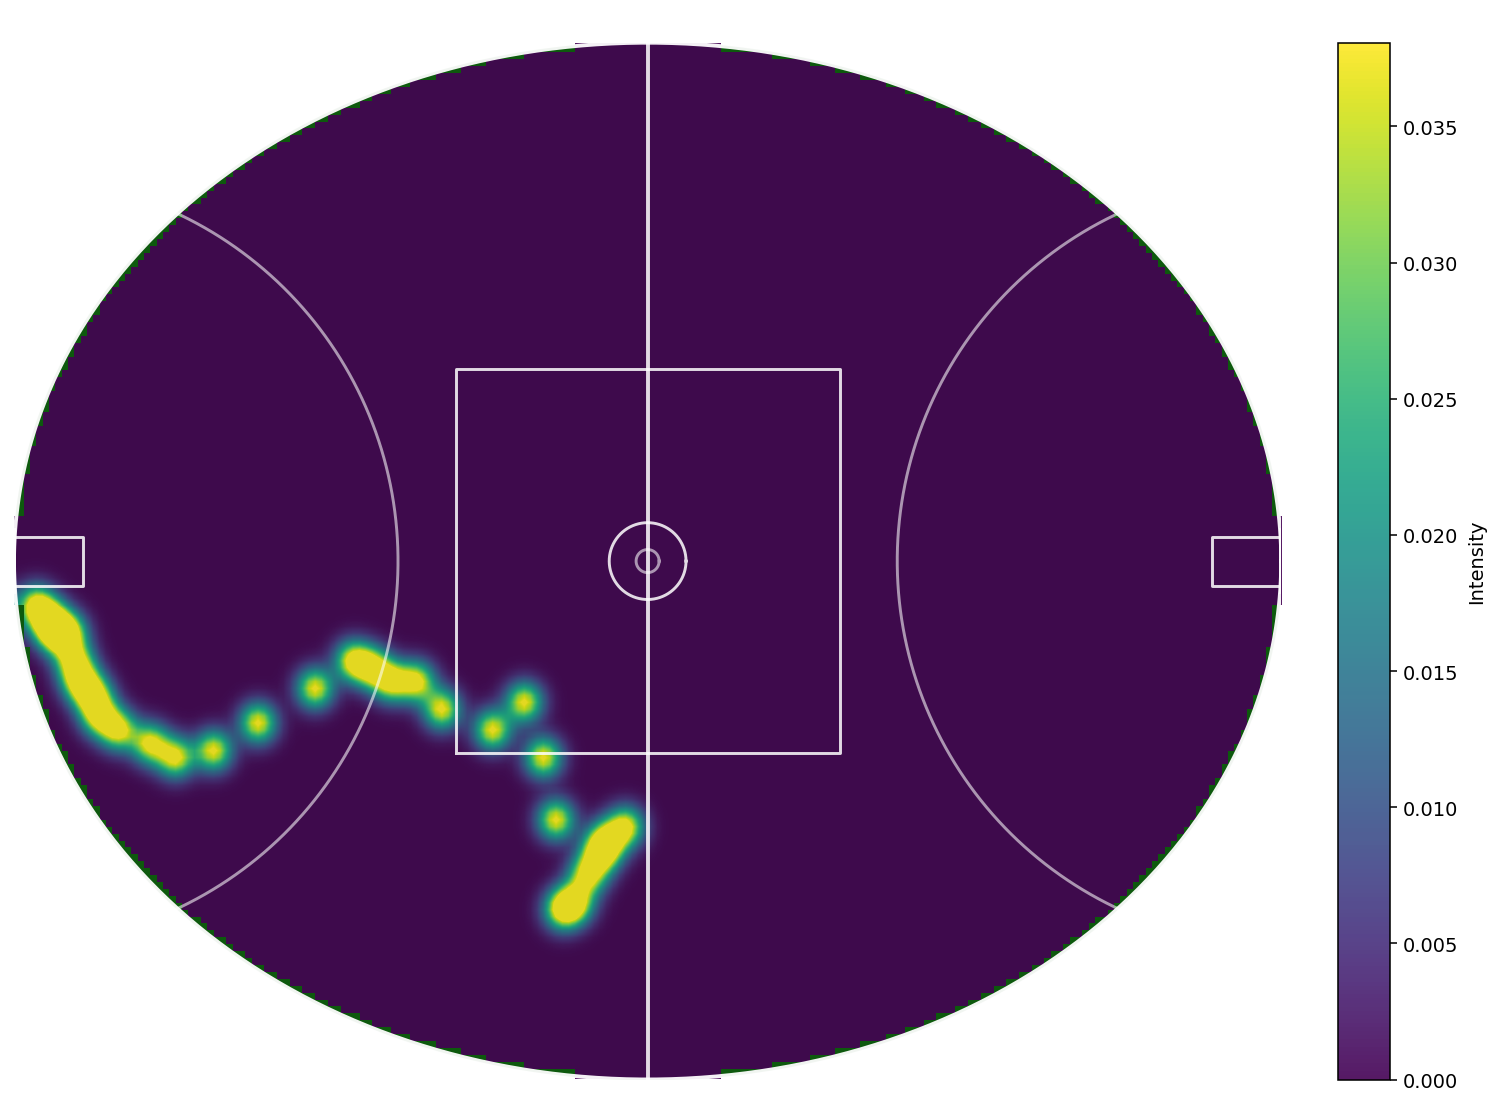

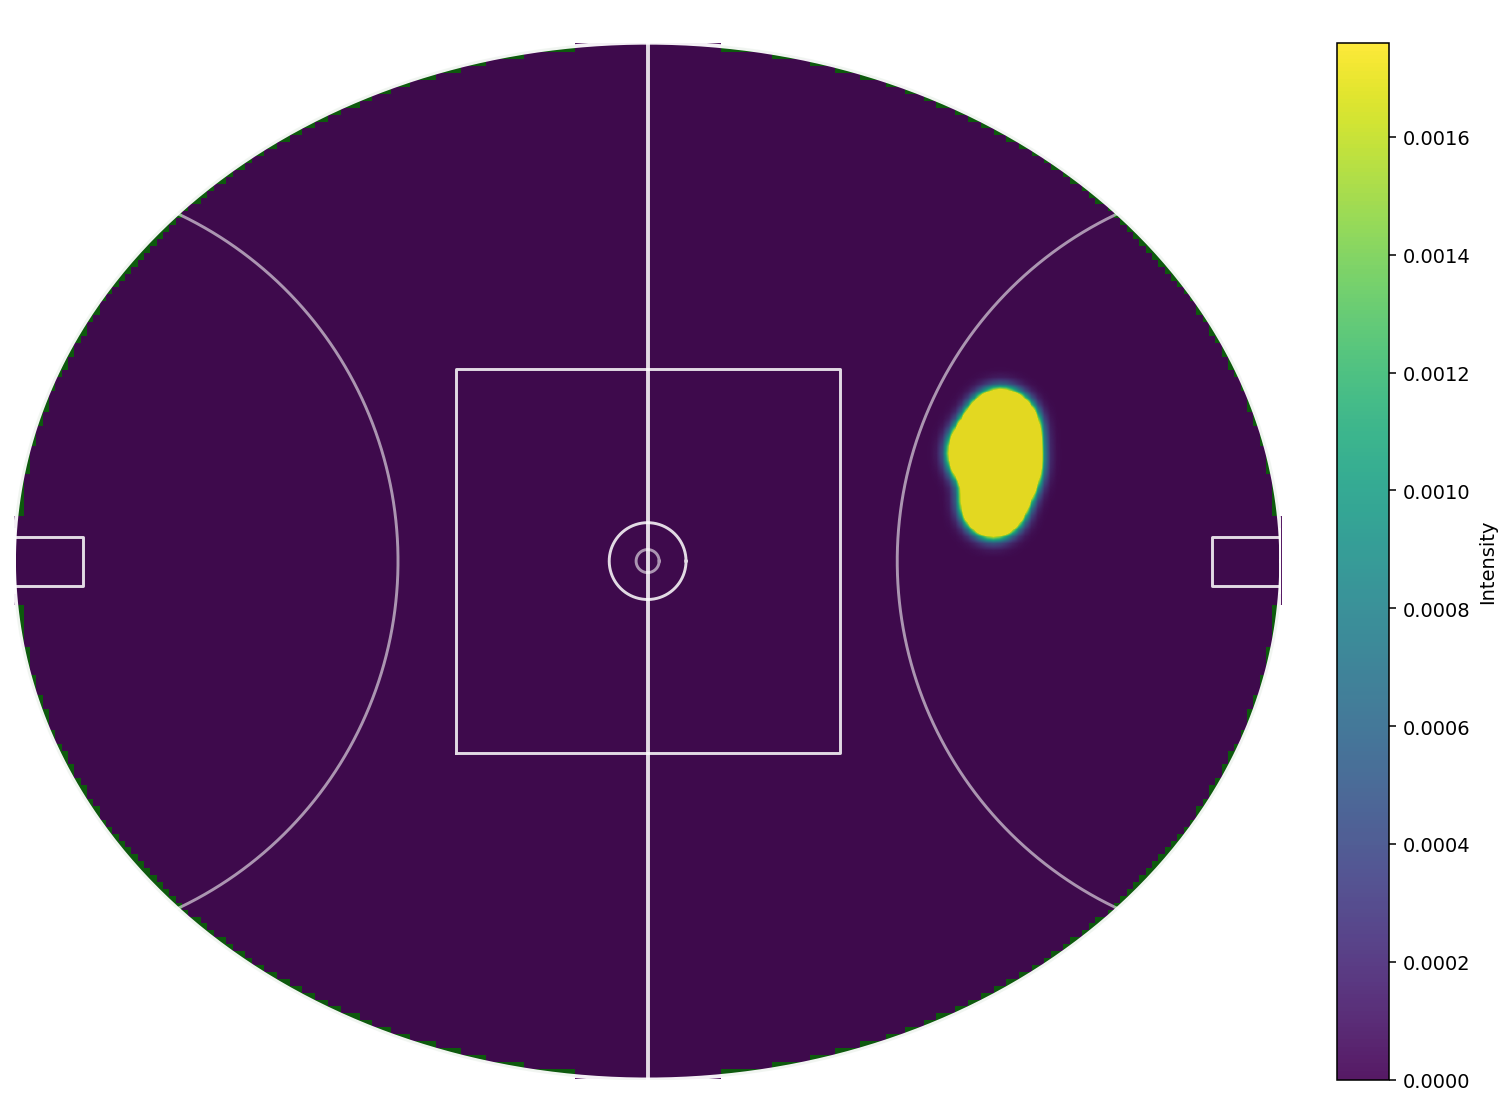

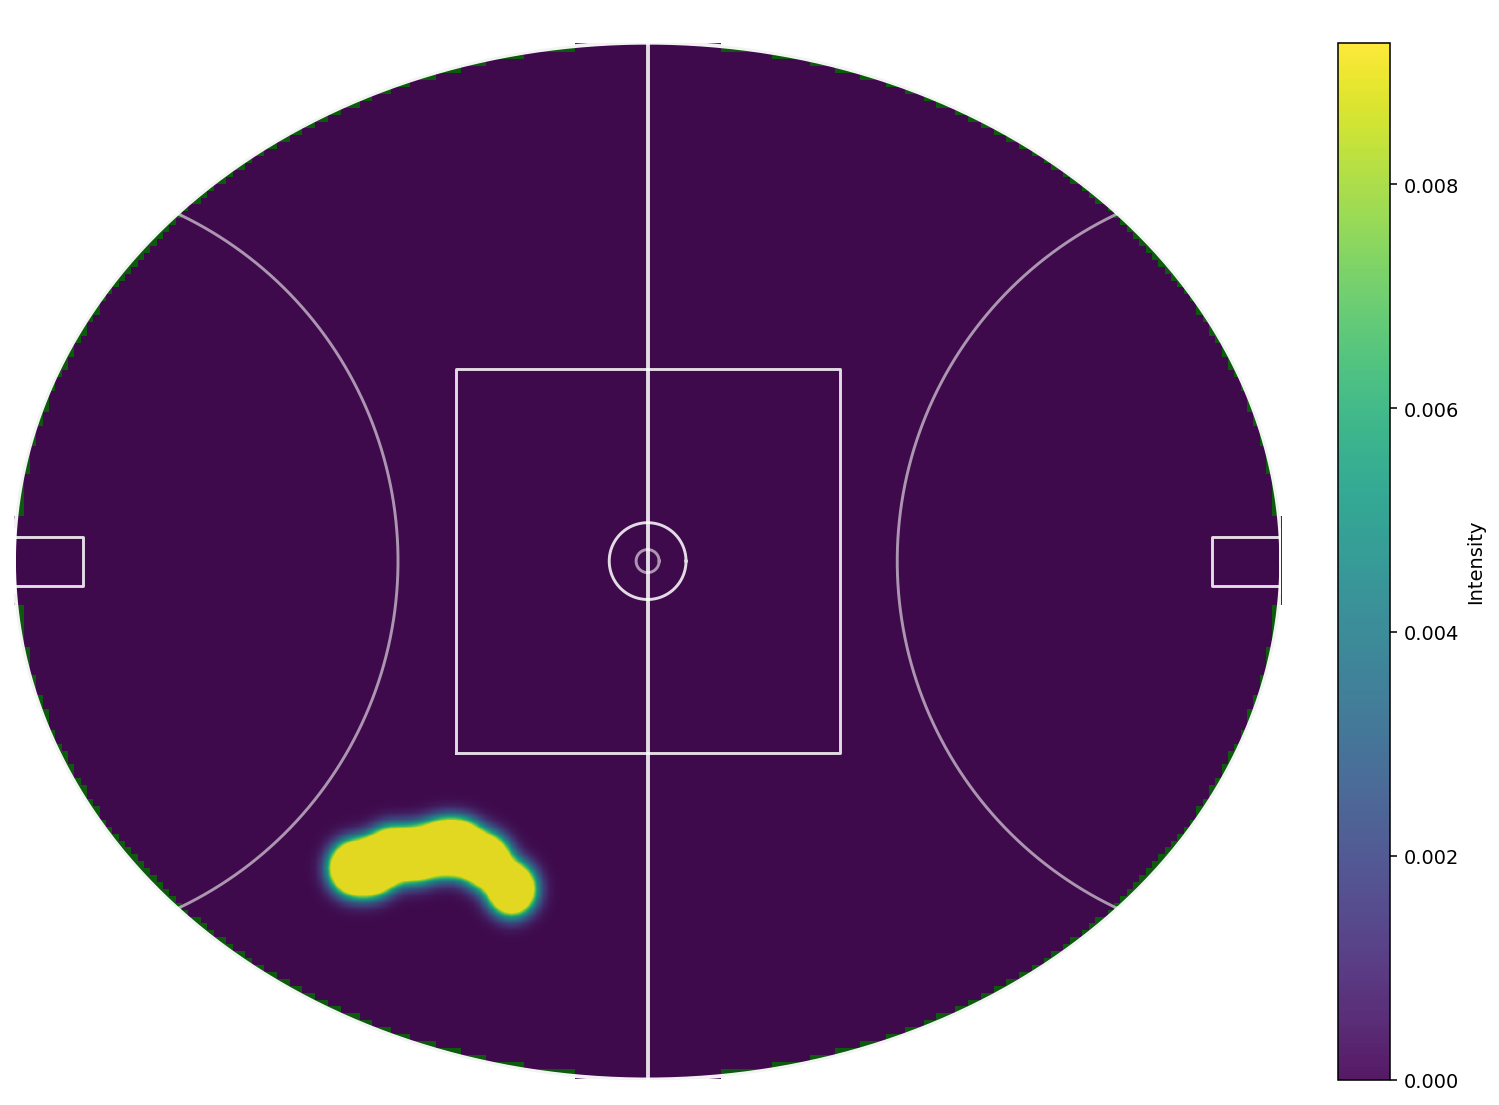

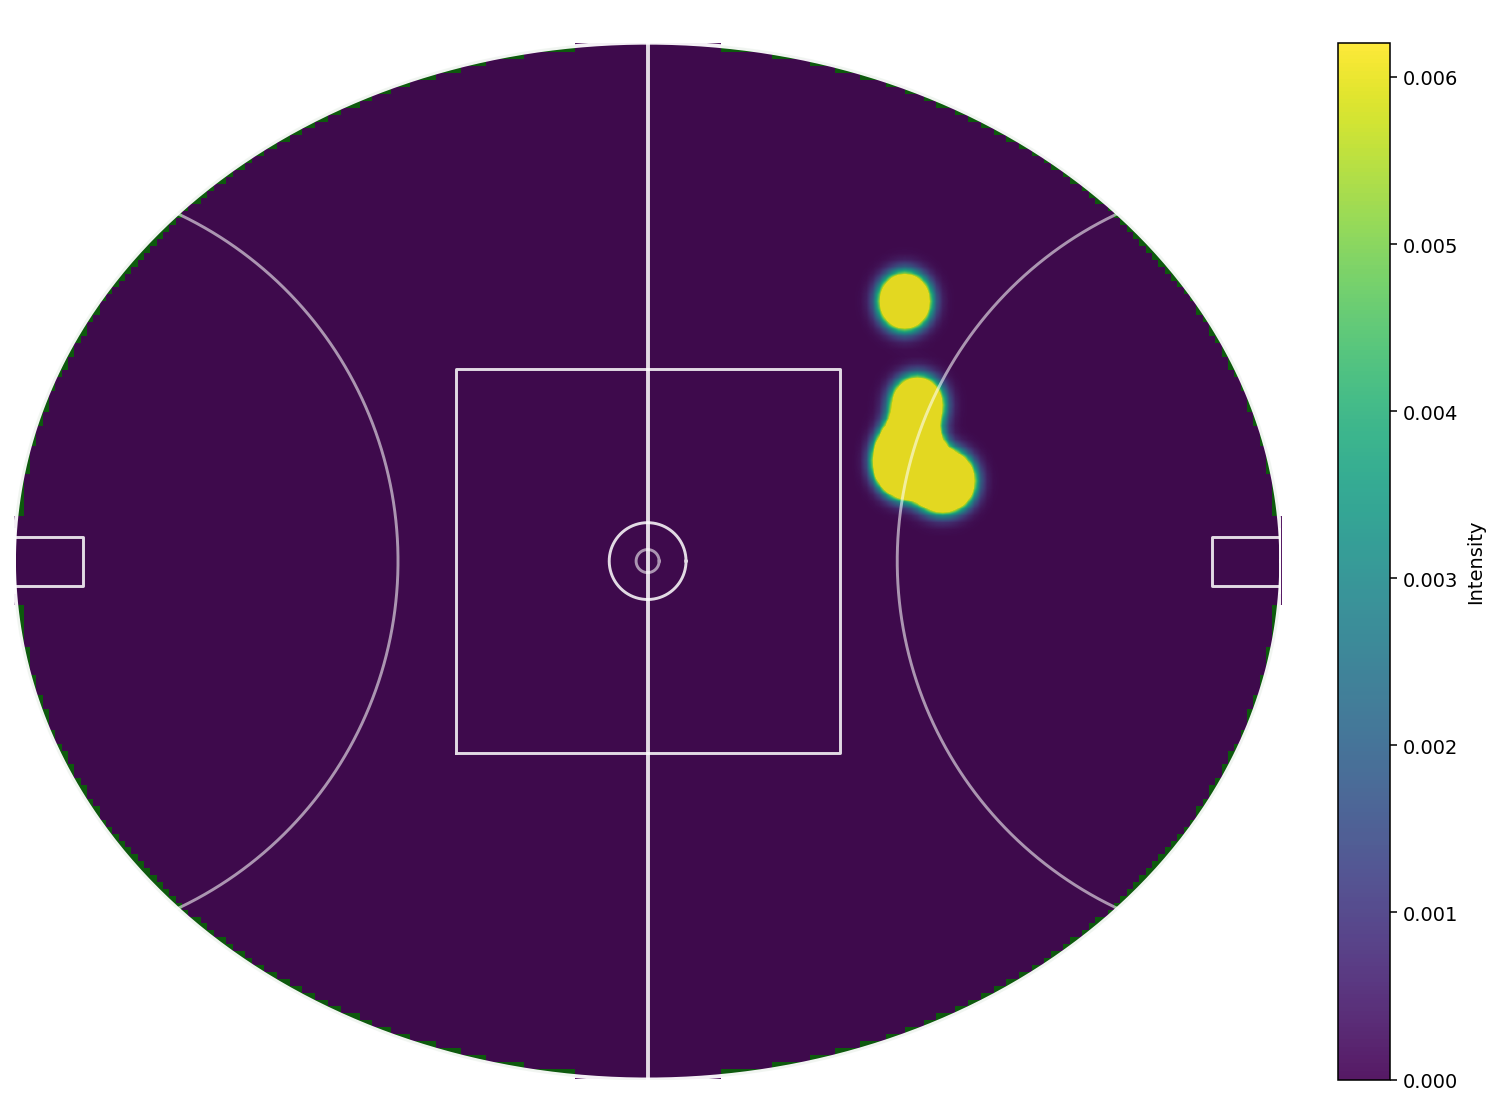

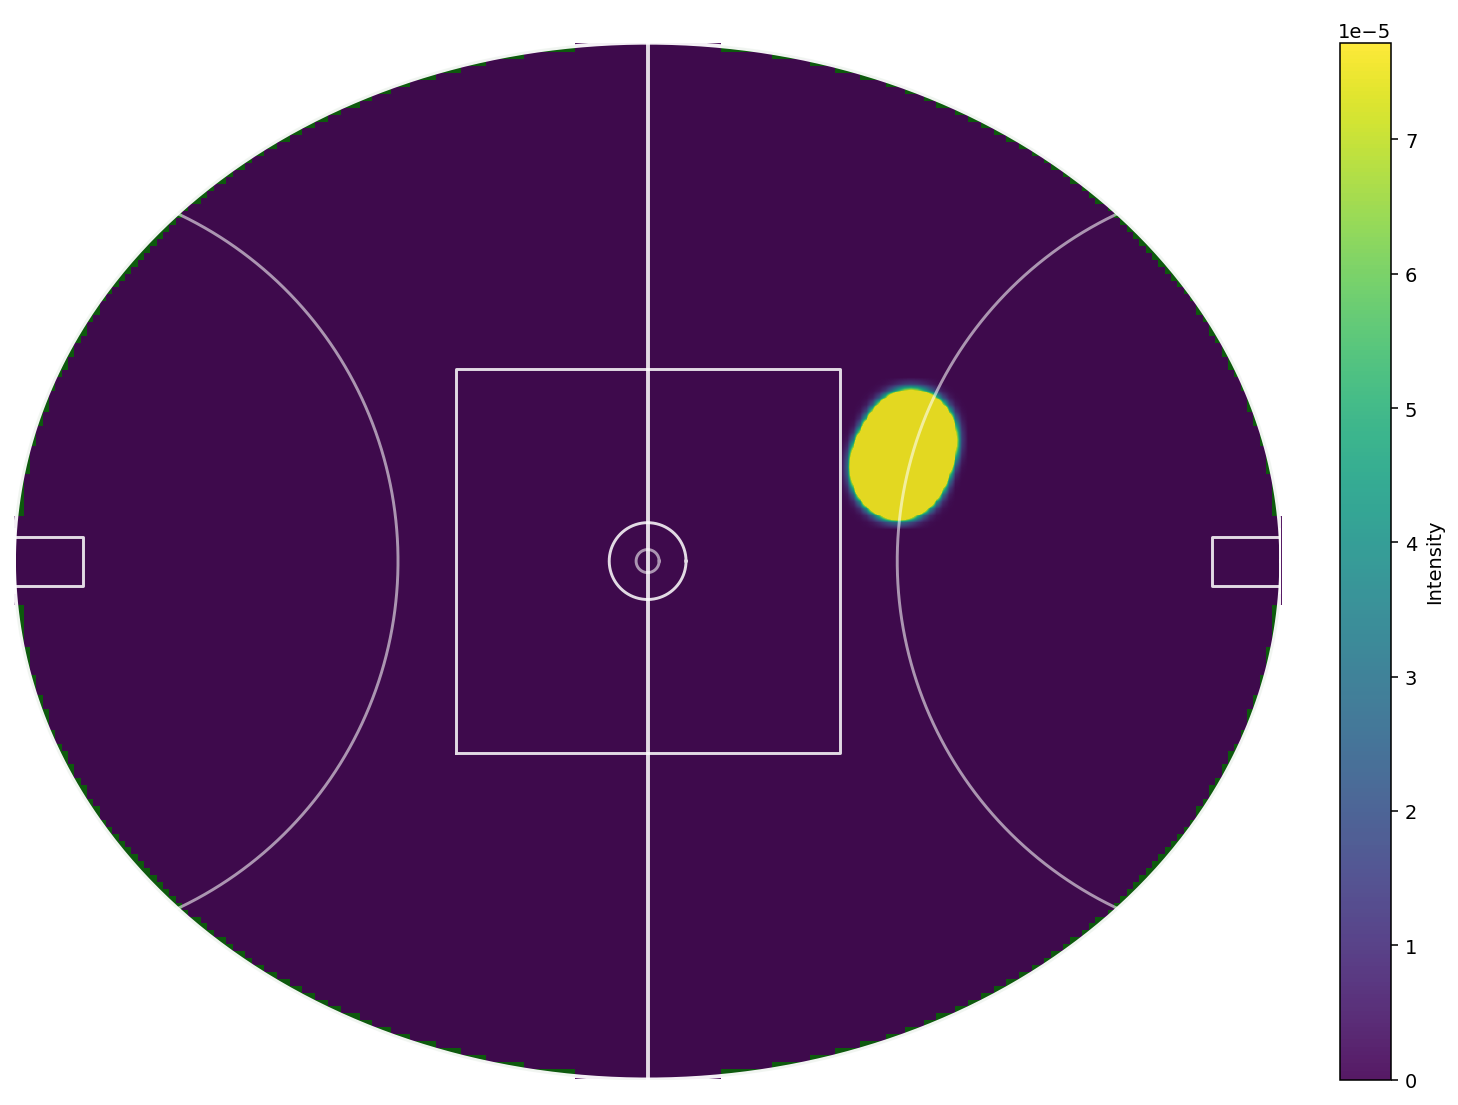

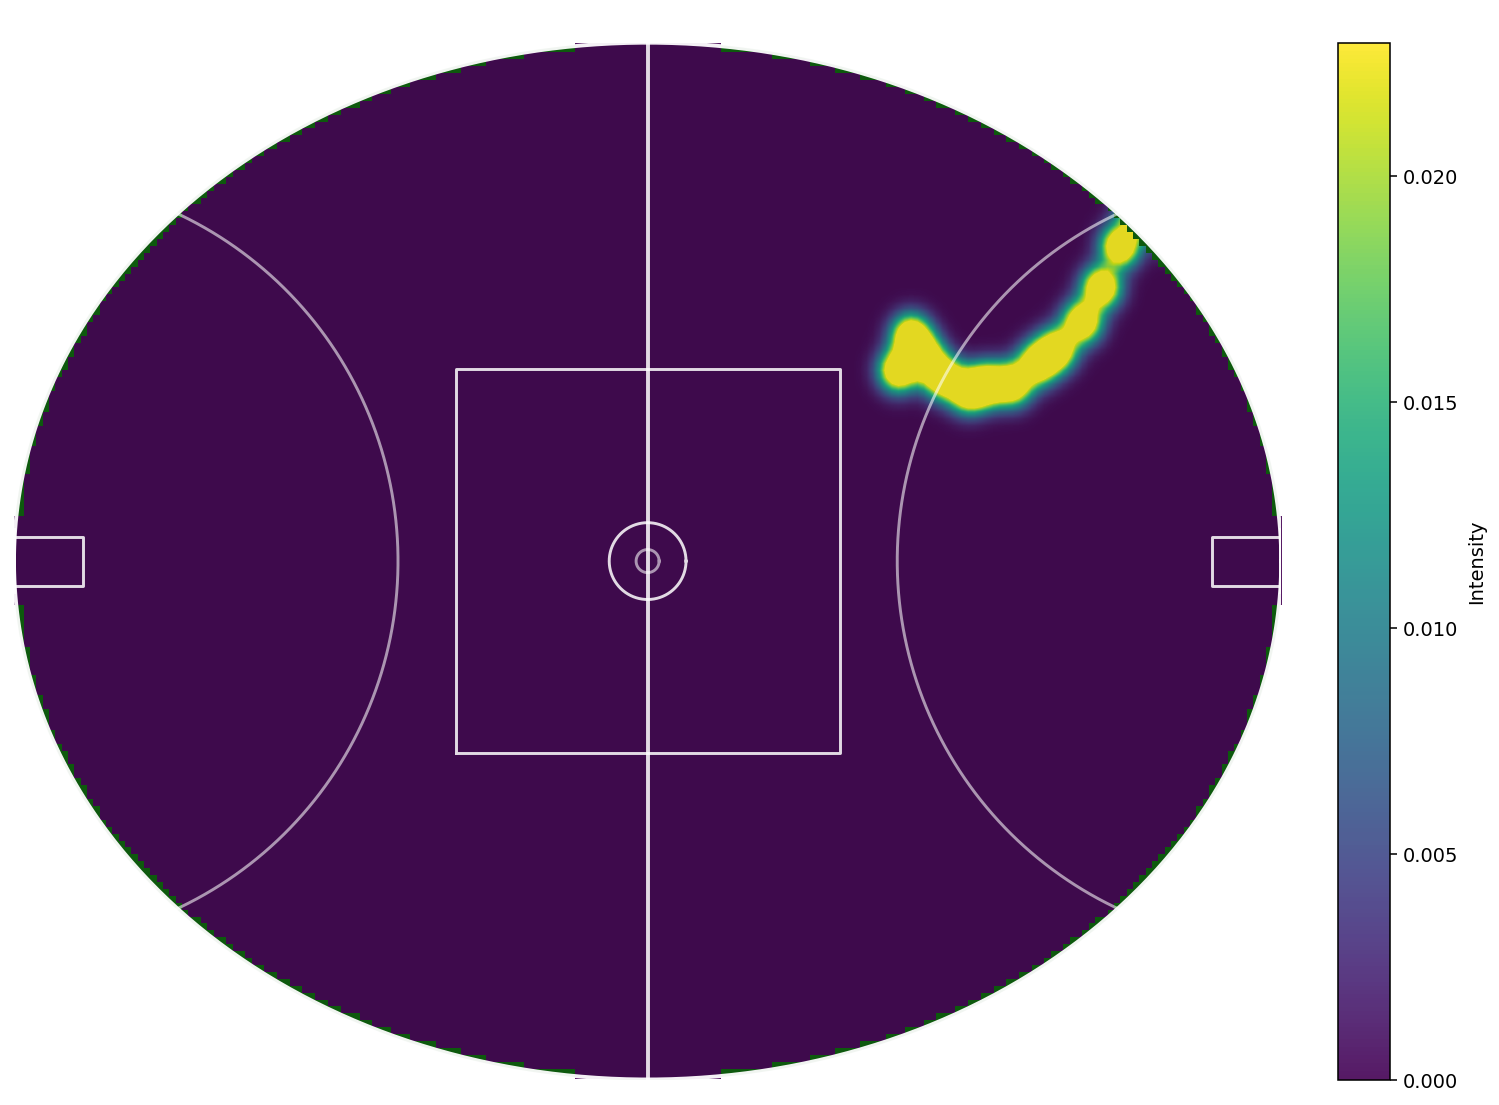

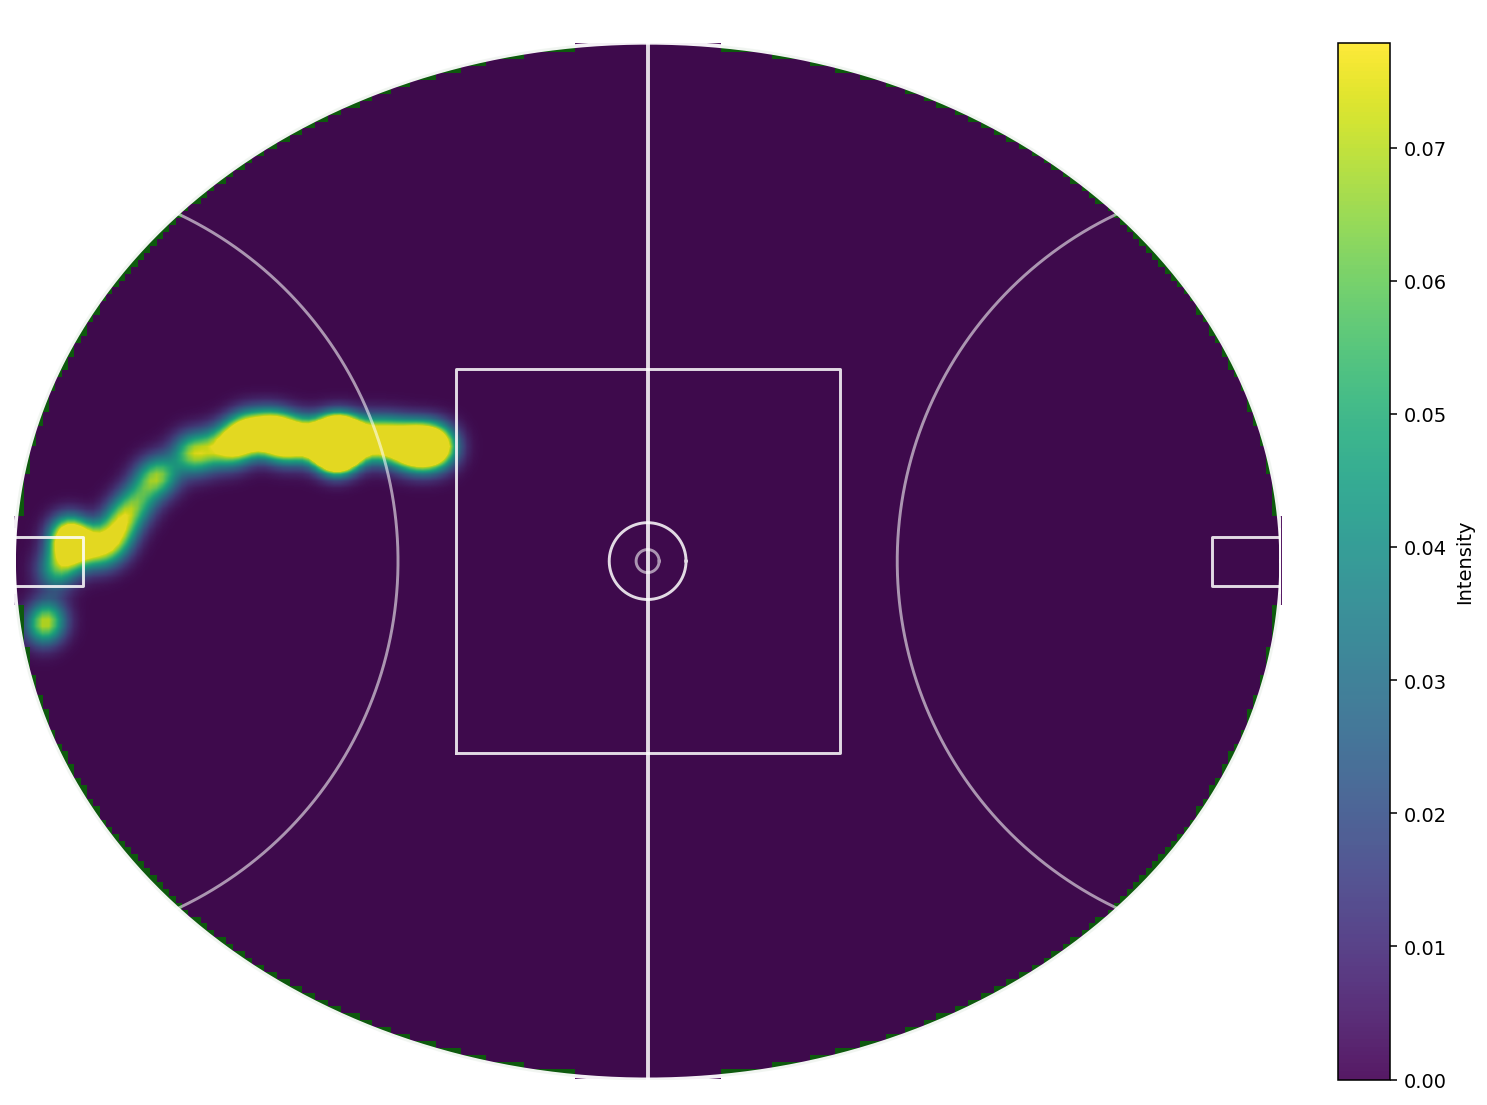

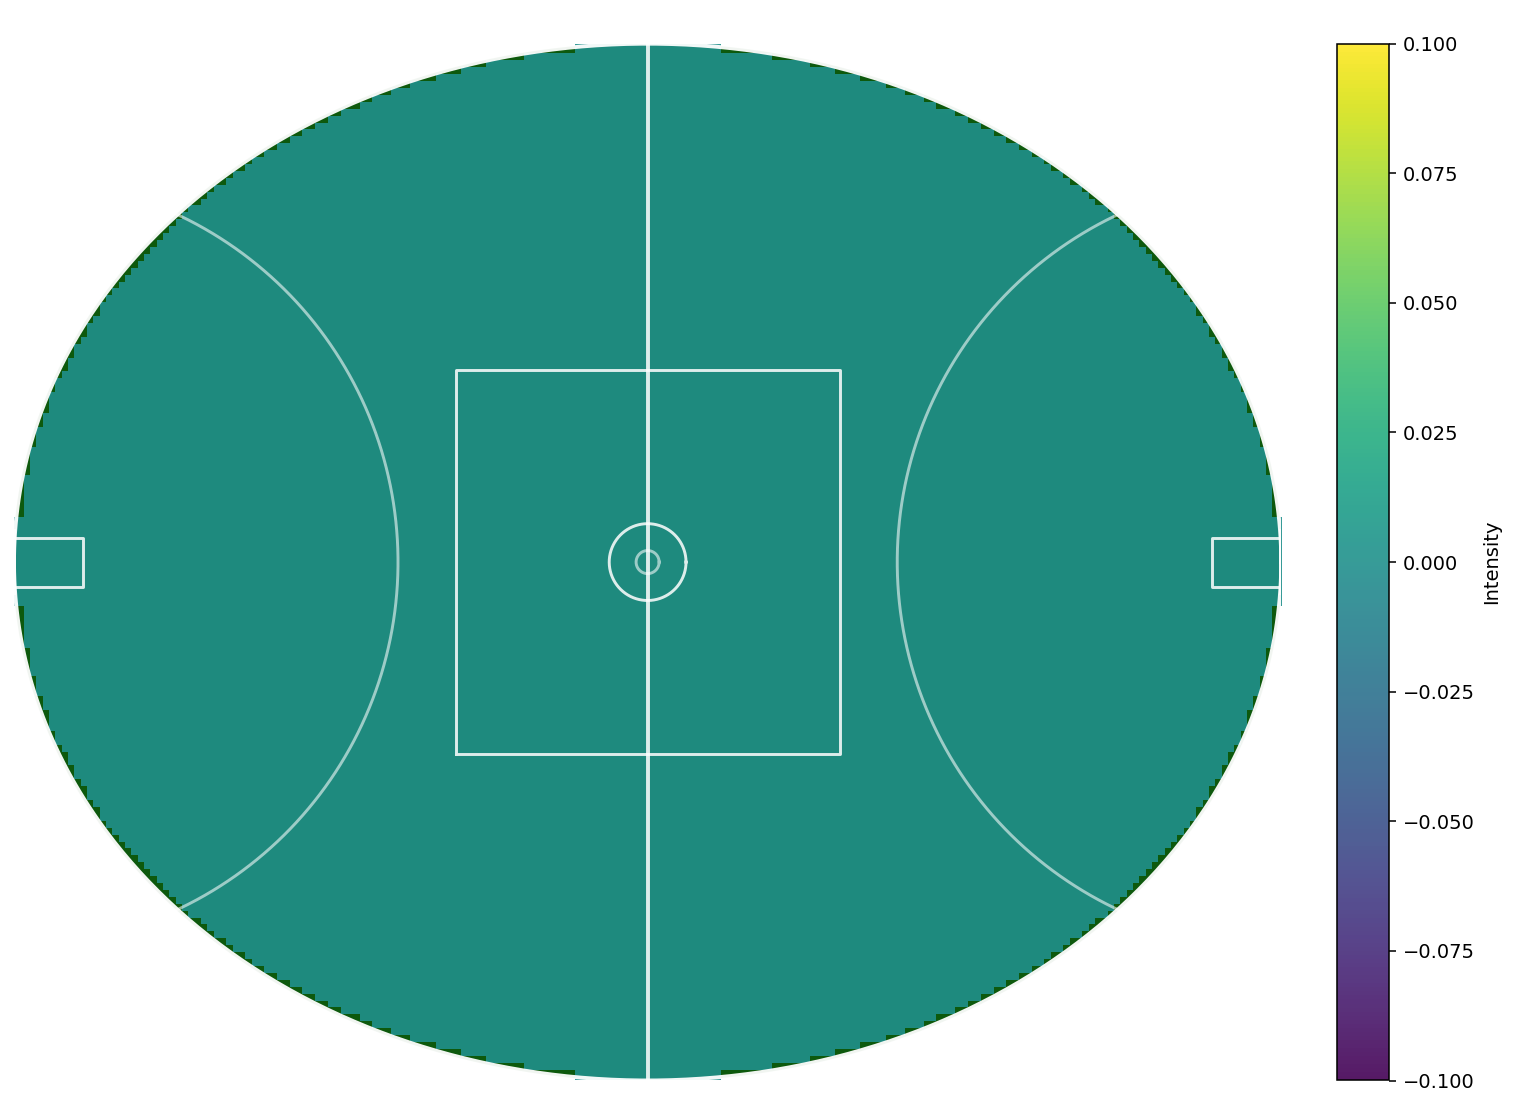

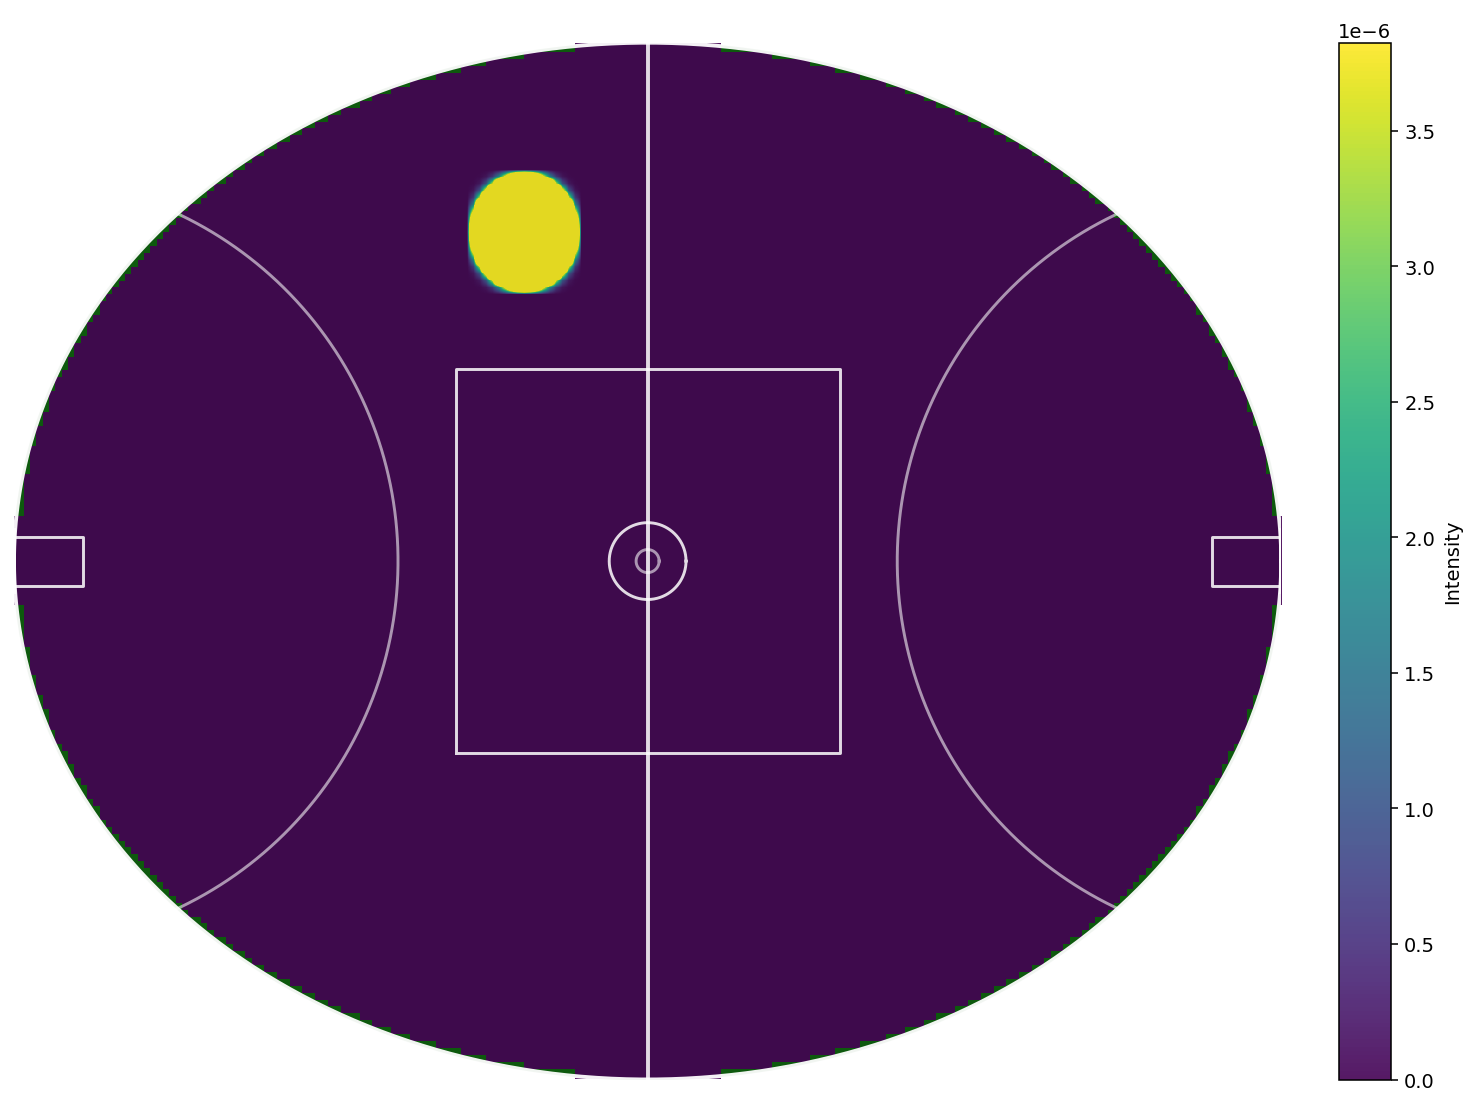

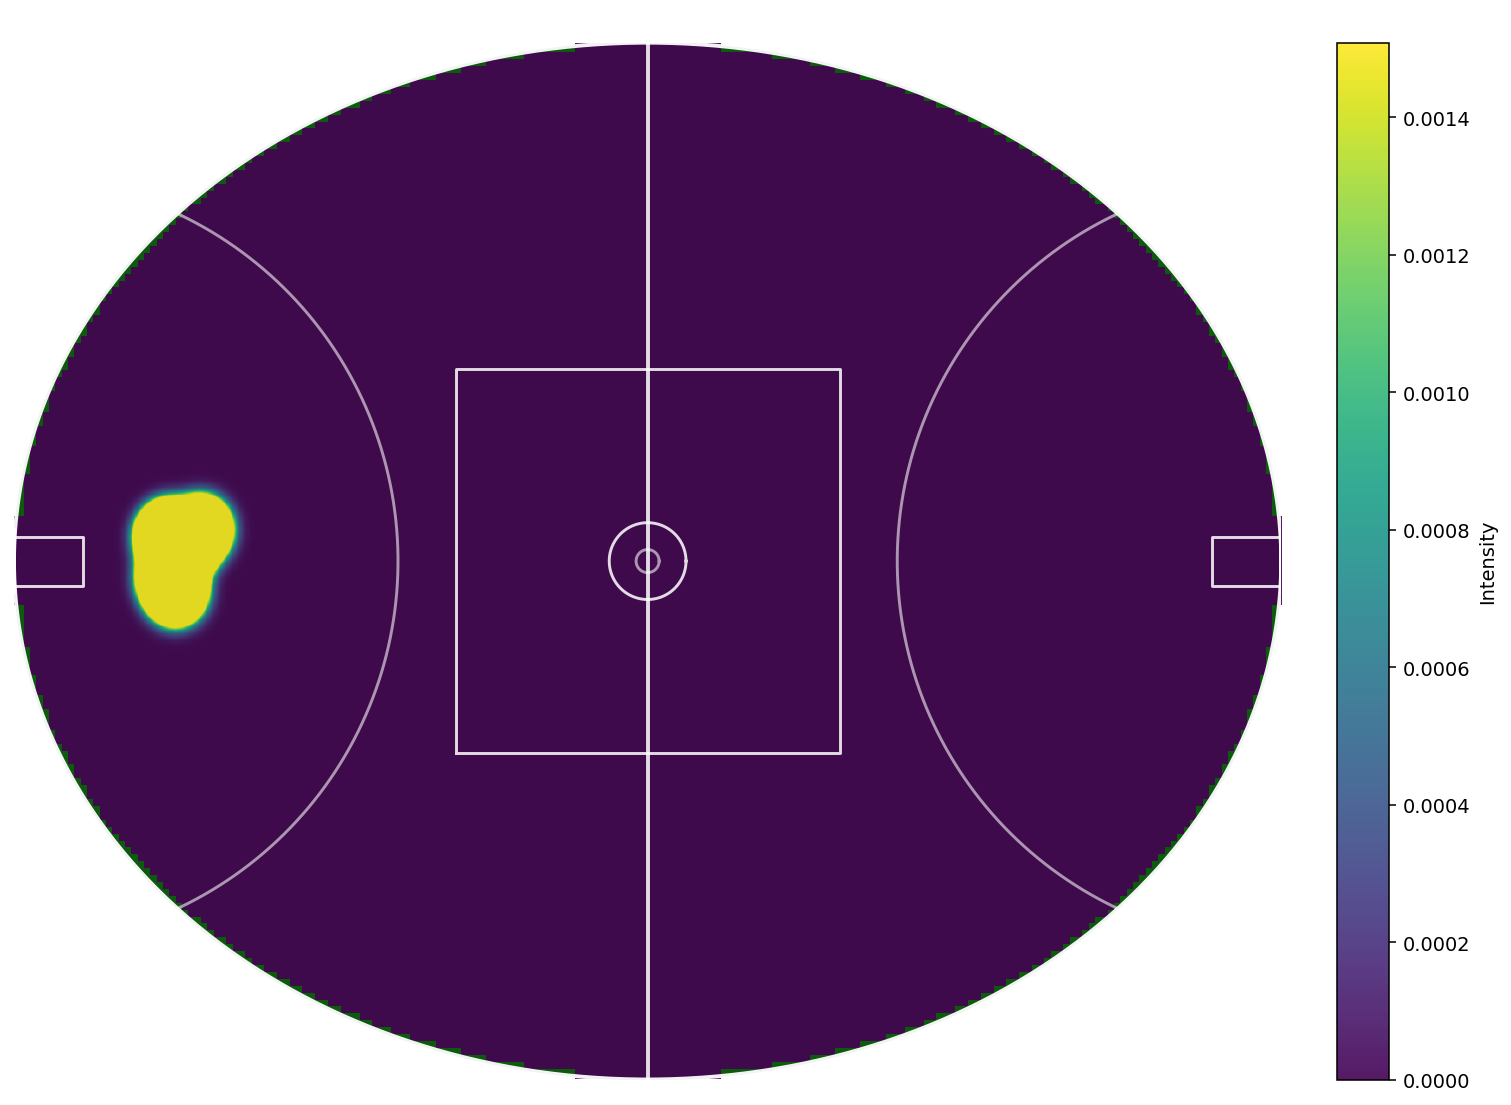

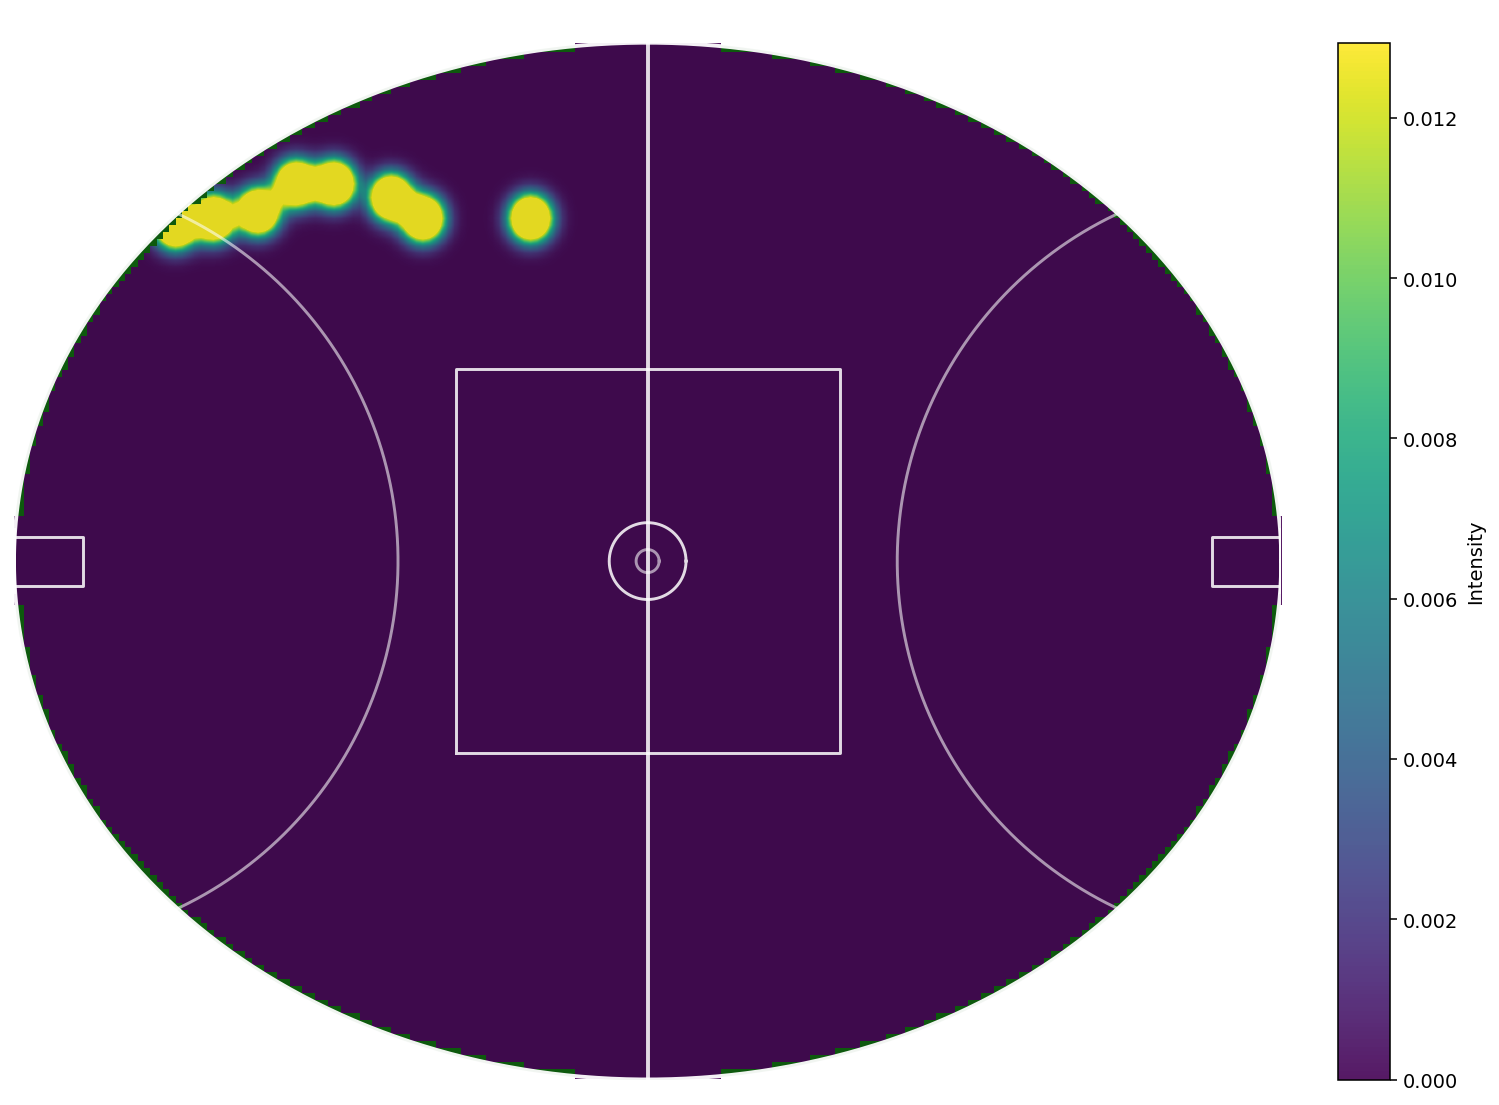

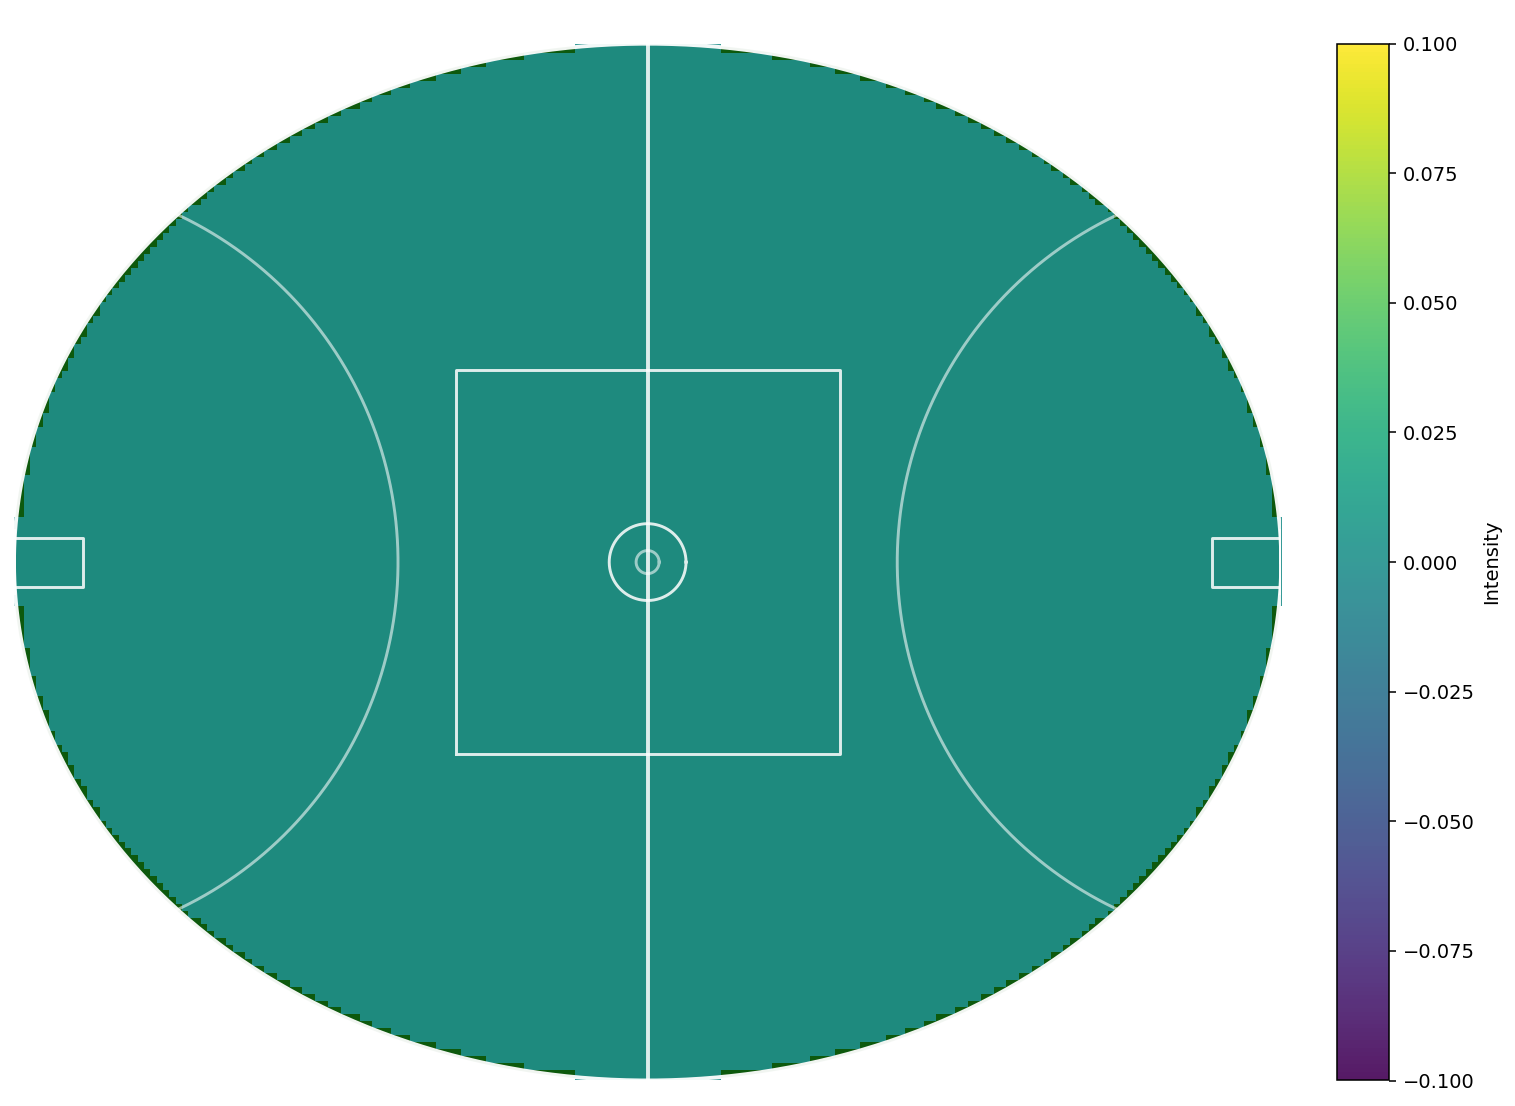

In [ ]:
for tid in df["player_id"].unique():
    sub_df = df[df["player_id"] == tid]


    H, xe, ye = heatmap_in_metres(
        sub_df["cx"], sub_df["cy"], bbox, a, b,
        nx=DEFAULT_NX, ny=DEFAULT_NY, sigma=DEFAULT_SIGMA
    )

    out_path = os.path.join(output_dir, f"player_{tid}.png")

    plot_heatmap_on_field_metres(H, xe, ye, a, b,
        title=f"Heatmap - Player {tid}",
        out_path=out_path
    )

In [ ]:
# Zip the outputs folder
!zip -r outputs.zip outputs/

# Download the zipped file
from google.colab import files
files.download('outputs.zip')

  adding: outputs/ (stored 0%)
  adding: outputs/individual_heatmaps/ (stored 0%)
  adding: outputs/individual_heatmaps/player_36.png (deflated 5%)
  adding: outputs/individual_heatmaps/player_1.png (deflated 5%)
  adding: outputs/individual_heatmaps/player_98.png (deflated 11%)
  adding: outputs/individual_heatmaps/player_34.png (deflated 9%)
  adding: outputs/individual_heatmaps/player_4.png (deflated 10%)
  adding: outputs/individual_heatmaps/player_88.png (deflated 8%)
  adding: outputs/individual_heatmaps/player_70.png (deflated 9%)
  adding: outputs/individual_heatmaps/player_69.png (deflated 9%)
  adding: outputs/individual_heatmaps/player_86.png (deflated 9%)
  adding: outputs/individual_heatmaps/player_73.png (deflated 9%)
  adding: outputs/individual_heatmaps/player_64.png (deflated 5%)
  adding: outputs/individual_heatmaps/player_45.png (deflated 10%)
  adding: outputs/individual_heatmaps/player_72.png (deflated 8%)
  adding: outputs/individual_heatmaps/player_2.png (deflate

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>